In [1]:
import os
import sys
import numpy as np
import networkx as nx
import itertools as it
import random as rd
import pickle as pk
import os.path
import pandas as pd
from collections import (defaultdict,Counter)
import time
import matplotlib.pyplot as plt


In [2]:
#Let's import the chemical-gene interactions from CTD (downloaded on 5th April 2021)
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', skipinitialspace=True)
#Here, we filter for only the interactions that regards the H. Sapiens
chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]

In [3]:
#Here, we create a dictionary out of the dataframe that has as a key the exposures and as 
#values the set of the genes that they perturb
chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])
        

        

In [133]:
#Let's count the number of references for each interaction
chem_gene_ref_df = chem_homo.groupby(['ChemicalID', 'GeneSymbol'])['PubMedIDs'].nunique().reset_index()

chem_gene_ref_df.to_csv("output/chem_gene_ref_df.tsv",sep="\t")
ref_list = chem_gene_ref_df['PubMedIDs'].tolist()
print(np.min(ref_list))
print(np.max(ref_list))
print(np.mean(ref_list))


1
283
1.214732086049021


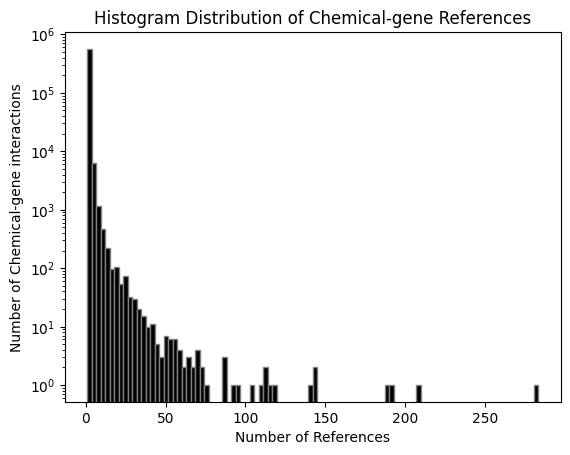

In [135]:
# Create a histogram
fig, ax = plt.subplots()
ax.hist(ref_list, bins=100, color='black', edgecolor='grey')
ax.set_yscale('log')
ax.set_xlabel('Number of References')
ax.set_ylabel('Number of Chemical-gene interactions')
ax.set_title('Histogram Distribution of Chemical-gene References')

plt.savefig('output/Figures/SF1A_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight") 
# Display the histogram
plt.show()

In [81]:
ref_list.count(1)

505372

In [12]:
#Let's create a new dictionary that contains only those chemical-gene interactions that have at least >1 reference 
#(in this way, we remove the majority of the interactions already)
chem_gene_hq = {}
for i,v in chem_gene_ref_df.iterrows():
    if v['PubMedIDs']>1:
        try:
            chem_gene_hq[v["ChemicalID"]] |= {v["GeneSymbol"]}
        except KeyError as e:
            chem_gene_hq[v["ChemicalID"]] = set([v["GeneSymbol"]])
    else:
        pass

In [13]:
len(chem_gene_hq)

2921

In [17]:
#On the other hand, we are creating another cheme-gene interactions dict, which have more interactions
#because we are going to include also the ones reported in mouse
chem_homo_mouse = chem_gene_df[chem_gene_df['Organism'].isin(['Homo sapiens', 'Mus musculus'])]


In [18]:
chem_gene_homo_mouse = {}
for i,v in chem_homo_mouse.iterrows():
    try:
        chem_gene_homo_mouse[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene_homo_mouse[v["ChemicalID"]] = set([v["GeneSymbol"]])
        
print(len(chem_gene_homo_mouse))

11416


/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_54862/2330179432.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(i) for i in list(ax1.get_yticks())], size = 36)


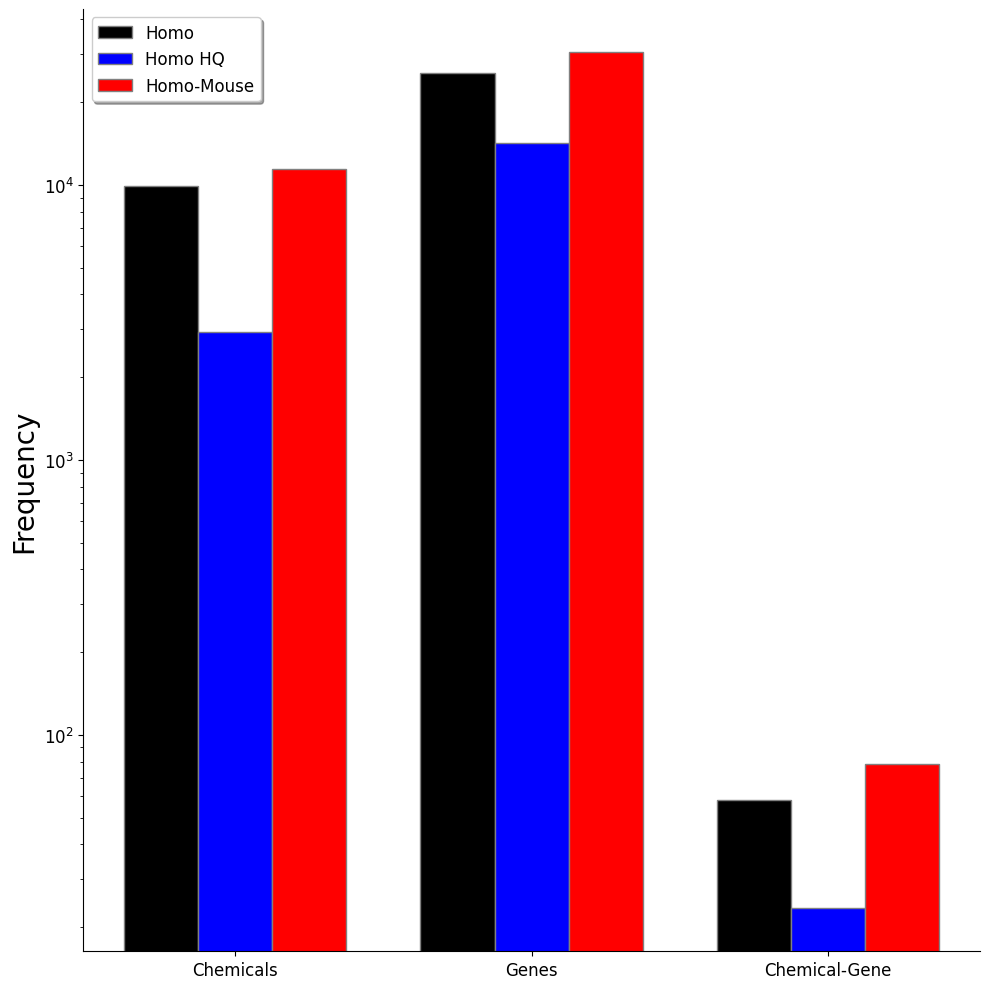

In [75]:

tot_chemlist_list = []
tot_gene_list = []
mean_chemgene_list = []

chem_gene_tot_gene_list = []
for chem,genelist in chem_gene.items():
    for gene in genelist:
        chem_gene_tot_gene_list.append(gene)           

tot_chemlist_list.append(len(chem_gene))
mean_chemgene_list.append(np.mean([len(v) for v in list(chem_gene.values())]))
tot_gene_list.append(len(set(chem_gene_tot_gene_list)))

chem_gene_hq_tot_gene_list = []
for chem,genelist in chem_gene_hq.items():
    for gene in genelist:
        chem_gene_hq_tot_gene_list.append(gene)           

tot_chemlist_list.append(len(chem_gene_hq))
mean_chemgene_list.append(np.mean([len(v) for v in list(chem_gene_hq.values())]))
tot_gene_list.append(len(set(chem_gene_hq_tot_gene_list)))


chem_gene_homo_mouse_gene_list = []
for chem,genelist in chem_gene_homo_mouse.items():
    for gene in genelist:
        chem_gene_homo_mouse_gene_list.append(gene)           

tot_chemlist_list.append(len(chem_gene_homo_mouse))
mean_chemgene_list.append(np.mean([len(v) for v in list(chem_gene_homo_mouse.values())]))
tot_gene_list.append(len(set(chem_gene_homo_mouse_gene_list)))

# define the width of bars
barWidth = 0.25 

fig1, ax1 = plt.subplots(figsize=(10, 10))

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

r1 = np.arange(len(tot_chemlist_list))    # position for tot chemicals bars
r2 = [x + barWidth for x in r1]     # position for tot genes bars
r3 = [x + barWidth for x in r2]     # position for mean cheme-genes bars

plt.bar(r1, [tot_chemlist_list[0],tot_gene_list[0],mean_chemgene_list[0]], color='black', width=barWidth, edgecolor='grey',label='Homo')  # degree bars
plt.bar(r2, [tot_chemlist_list[1],tot_gene_list[1],mean_chemgene_list[1]], color='blue', width=barWidth, edgecolor='grey',label='Homo HQ')  # gene bars
plt.bar(r3, [tot_chemlist_list[2],tot_gene_list[2],mean_chemgene_list[2]], color='red', width=barWidth, edgecolor='grey',label='Homo-Mouse')  # gene bars

# adding labels
ax1.set_xlabel('', fontsize=20)
ax1.set_ylabel('Frequency', fontsize=20)
plt.xticks([r + barWidth for r in range(len(tot_chemlist_list))], ['Chemicals','Genes','Chemical-Gene'], ha='center', fontsize=12)

ax1.set_yticklabels([int(i) for i in list(ax1.get_yticks())], size = 36)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.legend(loc='upper left', fontsize='large', shadow=True)
plt.savefig('output/Figures/SF1B_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")

plt.tight_layout()
plt.show()

In [39]:
#Let's save both dictionaries
with open('output/chem_gene_hq.pickle', 'wb') as handle:
    pk.dump(chem_gene_hq, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/chem_gene_homo_mouse.pickle', 'wb') as handle:
    pk.dump(chem_gene_homo_mouse, handle, protocol=pk.HIGHEST_PROTOCOL)

In [173]:
chem_id_name_conversion = {}
for i,v in chem_homo.iterrows():
        chem_id_name_conversion[v["ChemicalID"]] = v["# ChemicalName"]

In [87]:
#Here, we remove the elements that do not perturb any genes:       
chem_gene_cleaned = {}
tot_gene_list=[]
for k,v in chem_gene.items():
    if len(v)>0:
        chem_gene_cleaned[k]=v
        for gene in v:
            tot_gene_list.append(gene)           
    else:
        pass
 
print("The number of exposures is %s" %len(chem_gene_cleaned))
print("The total number of perturbed genes is %s" %len(set(tot_gene_list)))

The number of exposures is 9887
The total number of perturbed genes is 25580


In [6]:
#The number of genes is quite high, because there are included also: pseudogenes, lncRNA,
#miRNA and other non coding elements

In [159]:
#Let's build also the vice-versa: the gene-chem dictionary
gene_chem = {}
for i,v in chem_homo.iterrows():
    try:
        gene_chem[v["GeneSymbol"]] |= {v["ChemicalID"]}
    except KeyError as e:
        gene_chem[v["GeneSymbol"]] = set([v["ChemicalID"]])

In [160]:
#Here the cleaning process
gene_chem_cleaned={}
for k,v in gene_chem.items():
    if len(v)!=0:
        gene_chem_cleaned[k]=v
    else:
        pass
    

In [9]:
#Now, we will create a chemical ontology from the chemical vocabolary
#downloaded on 05.04.2021 from CTD

#First of all, we have to clean the dictionary, removing "MESH: " from the text
inputFile = open("input/CTD/CTD_chemicals.tsv", "r") 
exportFile = open("input/CTD/CTD_chemicals_cleaned.txt", "w")
for line in inputFile:
   new_line = line.replace('MESH:', '')
   exportFile.write(new_line) 

inputFile.close()
exportFile.close()


In [42]:
chem_vocabolary = pd.read_csv("input/CTD/CTD_chemicals_cleaned.txt",delimiter= '\t',
           skipinitialspace=True)
chem_voc_dict = {}
for i,v in chem_vocabolary.iterrows():
    try:
        chem_voc_dict[v["ChemicalID"]] = v["ParentIDs"].split("|")
    except:
        chem_voc_dict[v["ChemicalID"]] = v["ParentIDs"]


In [43]:
from collections.abc import Mapping
# Empty directed graph
G = nx.DiGraph()
for k in chem_voc_dict.keys():
    try:
        for v in chem_voc_dict[k]:
            G.add_edge(k, v)
    except:
        G.add_edge(k,"D") #we remove the general term "D" that refers to chemicals


In [11]:
#This shows that all the exposures are included in the ontology
for k in chem_gene_cleaned.keys():
    if k not in set(G.nodes()):
        print(k)

In [10]:
print("The number of elements in our chemical ontology is: %s" %G.number_of_nodes())

The number of elements in our chemical ontology is: 174240


In [44]:
#Here, we group all the chemicals in 12 categories, obtained extracting the
#second layer of the chemical ontology
classes_list=[]
for i in G.nodes():
    if len(nx.predecessor(G, i))==2:
        classes_list.append(i)

In [45]:
#Let's clean the list from the nan elements
classes_list_cleaned = [x for x in classes_list if str(x) != 'nan']

In [155]:
#Let's associate a specific color for each chemical group 
#colors=['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f'] 

#class_color_dict={}
#for i in range(len(classes_list_cleaned)):
#    class_color_dict[classes_list_cleaned[i]]=colors[i]

class_color_dict = {}

class_color_dict['D011083']='#00AEEF'
class_color_dict['D006571']='#64A8C5'
class_color_dict['D008055']='#FBB040'
class_color_dict['D009930']='#44C8F5'
class_color_dict['D045424']='#F79D8D'
class_color_dict['D007287']='#BCBEC0'
class_color_dict['D002241']='#FECD8A'
class_color_dict['D001685']='#F15A29'
class_color_dict['D000602']='#F9A86B'
class_color_dict['D020164']='#FFE6CB'
class_color_dict['D045762']='#D56B4C'
class_color_dict['D009706']='#C65D7D'


In [ ]:
#Let's create a dictionary where for each chemical class we have the exposures
#that belongs to that class
d_classes = {}
for j in classes_list_cleaned:
    j_list=[]
    for i in chem_gene_cleaned.keys(): 
        if j in nx.predecessor(G, i):
            j_list.append(i)
    d_classes[j]=j_list


In [76]:
#Let's write the results in the intermidiate folder
with open('intermediate/d_classes.pickle', 'wb') as handle:
    pk.dump(d_classes, handle, protocol=pk.HIGHEST_PROTOCOL)

In [55]:
with open('intermediate/d_classes.pickle', 'rb') as handle:
    d_classes = pk.load(handle)

In [18]:
for k1, geneset1 in d_classes.items():
    for k2, geneset2 in d_classes.items():
        if k1!=k2:
            if geneset1 in geneset2:
                print(k1,k2)

In [20]:
#Let's look at the number of exposures belonging in each chemical class
d_classes_len={}
for k,v in d_classes.items():
    d_classes_len[k]=len(v)
    

In [19]:
#Here we compute the ratio of each chemical class, but since that there are many 
#elements that are in multiple classes, we are calculating the ration on the sum
#of all the previous lenghts (meaning that we will count an exposure as many times
#as it is repeated (i.e. if the same exposure belongs to 5 chemical classes than
#it will be considered as we have 5 different exposures))
tot=0
for v in d_classes_len.values():
    tot=tot+v
d_classes_len_fractio={}
for k,v in d_classes_len.items():
    d_classes_len_fractio[k]=v/tot  

In [137]:
size_list=[]
for v in d_classes_len.values():
    size_list.append(v)
avg_size= sum(size_list)/len(size_list)

In [162]:
#Let's convert the 12 classes to names 
chem_class_name_dict={}
chem_class_name_dict['D011083']='Polycyclic Compounds'
chem_class_name_dict['D006571']='Heterocyclic Compounds'
chem_class_name_dict['D008055']='Lipids'
chem_class_name_dict['D009930']='Organic Chemicals'
chem_class_name_dict['D045424']='Complex Mixtures'
chem_class_name_dict['D007287']='Inorganic Chemicals'
chem_class_name_dict['D002241']='Carbohydrates'
chem_class_name_dict['D001685']='Biological Factors'
chem_class_name_dict['D000602']='Amino Acids, Peptides, and Proteins'
chem_class_name_dict['D020164']='Chemical Actions and Uses'
chem_class_name_dict['D045762']='Enzymes and Coenzymes'
chem_class_name_dict['D009706']='Nucleic Acids, Nucleotides, and Nucleosides'







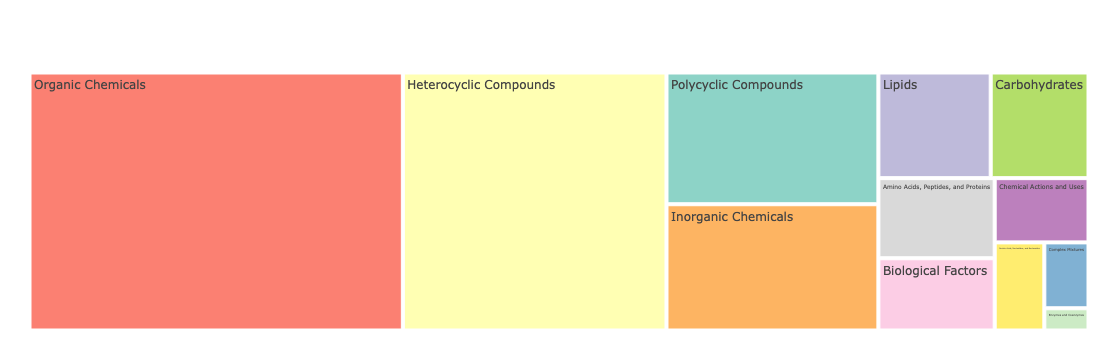

In [21]:
import plotly.graph_objects as go

chemclass_list=[]
parent_list=[]
color_list=[]
size_list=[]

for chem,num_exp in d_classes_len.items():
    chemclass_list.append(chem_class_name_dict[chem])
    parent_list.append("")
    color_list.append(class_color_dict[chem])
    size_list.append(num_exp)

fig = go.Figure(go.Treemap(
    labels = chemclass_list,
    values = size_list,
    parents = parent_list,
    marker_colors = color_list
))

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
#fig.write_image('output/Figures/Fig1A_treemap.pdf')    #This is final Fig. 1B
fig.show()

In [48]:
#Here, we define the 14 biological classes from CTD
biological_class =['folding','metabolic','stability','splicing','mutagenesis','localization','abundance','response_to_substance','transport','binding','activity','reaction','cotreatment','expression']


In [51]:
bio_el_fraction = {}    #Let's create a dictionary with the total fraction of associations for each biological class
bio_el_gene_dict = {}   #Let's create a dictionary with the associated genes to each biological class
for bio_el in biological_class:
    associations = []
    gene_list = []
    for i,v in chem_homo.iterrows():
        if bio_el in v['InteractionActions']:
            associations.append(str(v['ChemicalID'])+','+str(v['GeneSymbol']))
            gene_list.append(str(v['GeneSymbol']))
    bio_el_fraction[bio_el]=len(set(associations))/573674     #This is the total number of associations
    bio_el_gene_dict[bio_el] = set(gene_list)

In [113]:
for k,v in bio_el_fraction.items():
    print(k,v*573674)

folding 346.0
metabolic 3132.0
stability 526.0
splicing 608.0
mutagenesis 748.0
localization 4216.0
abundance 22264.0
response_to_substance 0.0
transport 1425.0
binding 22626.0
activity 28408.0
reaction 59394.0
cotreatment 110505.0
expression 476695.00000000006


In [114]:
for k,v in bio_el_fraction.items():
    print(k,v)

folding 0.0006031300006623971
metabolic 0.005459546711198346
stability 0.0009168970530301181
splicing 0.0010598353768865245
mutagenesis 0.001303876417616974
localization 0.0073491216265684
abundance 0.03880949807730523
response_to_substance 0.0
transport 0.0024839891645777917
binding 0.03944051848262253
activity 0.04951941346479011
reaction 0.10353266837960236
cotreatment 0.19262682289941674
expression 0.8309510279357266


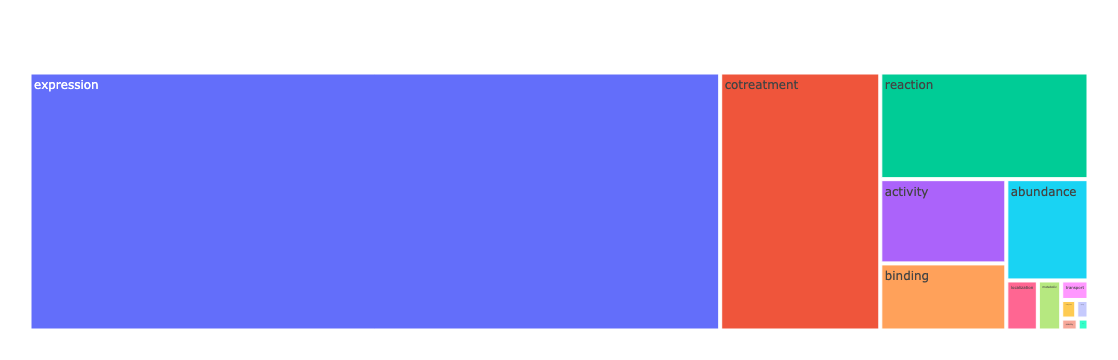

In [25]:
import plotly.graph_objects as go
import random

bioclass_list=[]
parent_list=[]
color_list=[]
size_list=[]

for biochem,fr in bio_el_fraction.items():
    bioclass_list.append(biochem)
    parent_list.append("")
    color = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(14)])
    color_list.append(color)
    size_list.append(fr*573674)

fig = go.Figure(go.Treemap(
    labels = bioclass_list,
    values = size_list,
    parents = parent_list,
    marker_colors = color_list
))

fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
#fig.write_image('output/Figures/Fig1B_treemap.pdf')  #This is the final version of Fig1C
fig.show()

In [32]:
#Let's create a dictionary that contains the number of classes for each chemical
chem_class_freqeuncy={}
for chem in chem_gene_cleaned.keys():
    c=0
    for k,v in d_classes.items():
        if chem in v:
            c=c+1
        else:
            pass
    chem_class_freqeuncy[chem]=c

In [56]:
#Let's write the results in the intermidiate folder
with open('intermediate/chem_class_freqeuncy.pickle', 'wb') as handle:
    pk.dump(chem_class_freqeuncy, handle, protocol=pk.HIGHEST_PROTOCOL)

In [37]:

#Get the unique multi class frequency 
frequency_unique = list(set(chem_class_freqeuncy.values()))

frequency_unique_dict={}
for el in frequency_unique:
    c=0
    for k,v in chem_class_freqeuncy.items():
        if el==v:
            c=c+1
        else:
            pass
    frequency_unique_dict[el]=c


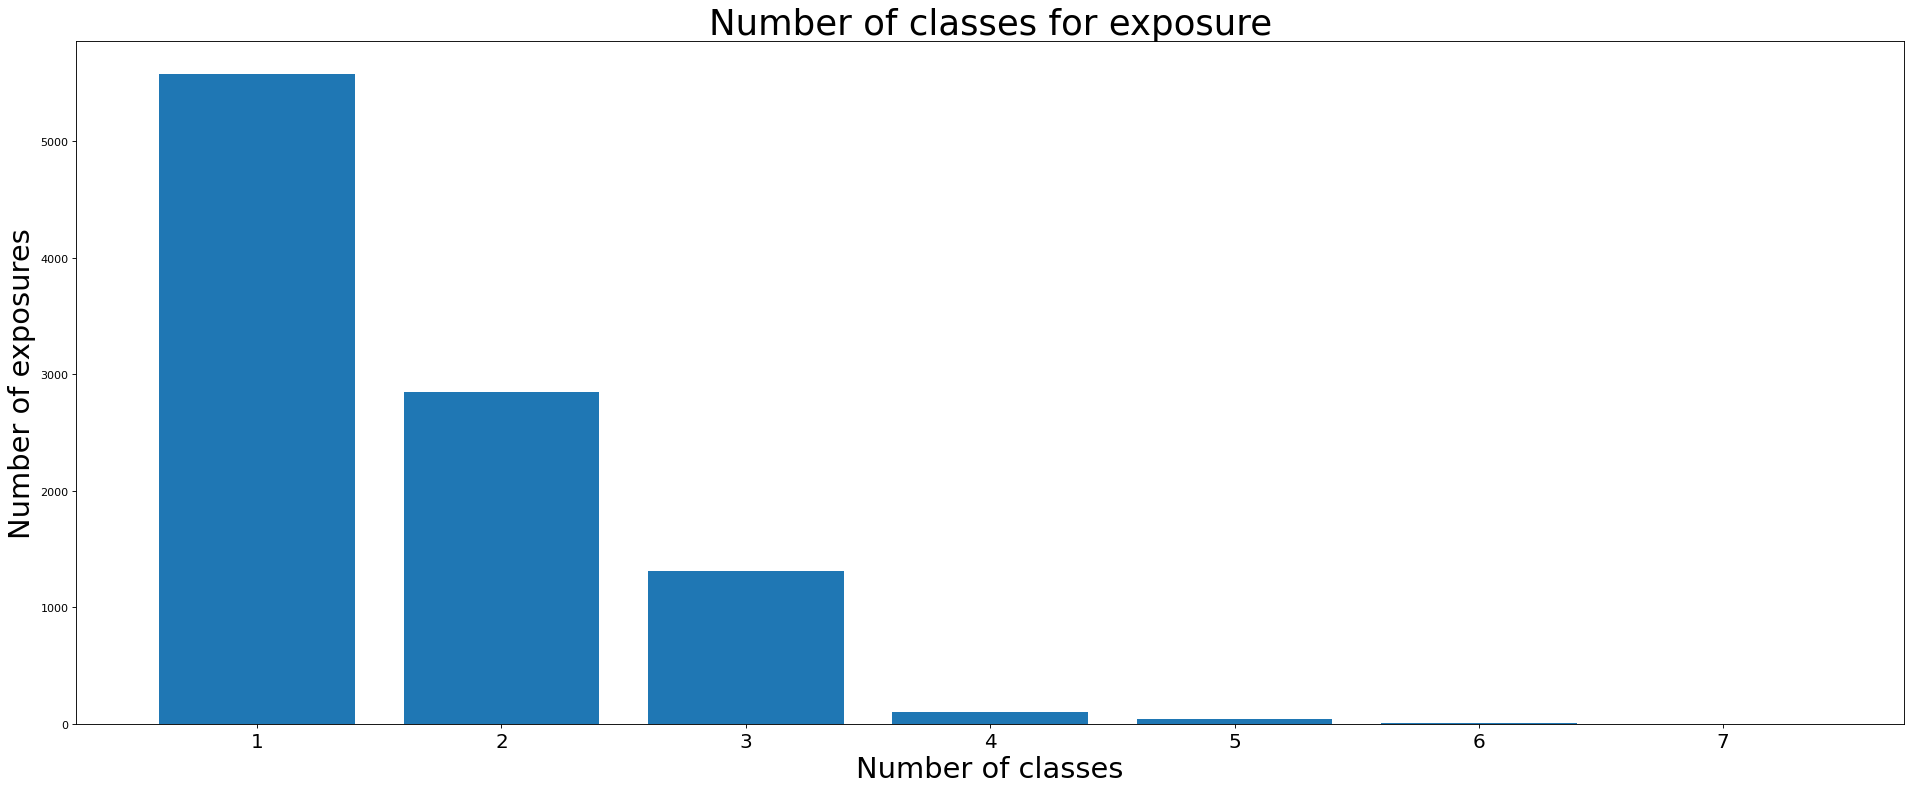

In [44]:
#Let's plot the frequency distribution
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

figure(num=None, figsize=(24, 10), dpi=80, facecolor='w', edgecolor='k')
x = np.arange(7)
label=[]
for i in range(7):
    label.append(i+1)
plt.bar(x, list(frequency_unique_dict.values()))
plt.title('Number of classes for exposure',fontsize=32)
plt.ylabel('Number of exposures',fontsize=26)
plt.xlabel('Number of classes',fontsize=26)
plt.xticks(x, label,fontsize=18)
plt.tight_layout()
plt.show()

In [72]:
#Here, I want to check which are the combinations of chemical classes that occurs the most in our dataset
quntitative_chem_class_frequency={}
for i in range(2,8):
    comb_class_list=[]
    for chem, freq in chem_class_freqeuncy.items():
        if i==freq:
            comb_class=str()
            for k,v in d_classes.items():
                if chem in v:
                    comb_class+=k
                    comb_class+=","
                else:
                    pass
            comb_class_list.append(comb_class[:-1])
        else:
            pass
    quntitative_chem_class_frequency[i]=comb_class_list

In [73]:
quntitative_chem_class_frequency_count={}
for k,v in quntitative_chem_class_frequency.items():
    quntitative_chem_class_frequency_count[k]=Counter(v).most_common()

In [74]:
quntitative_chem_class_frequency_count[7]

[('D011083,D009930,D045424,D002241,D001685,D000602,D020164', 1)]

In [67]:

import scipy  
from scipy import stats

def overlap_jaccard(list1,list2):
    intersction_term= len(set(list1) & set(list2))
    denominator = len(set(list1).union(set(list2)))
    overlap_jaccard_coeff = intersction_term/denominator
    return overlap_jaccard_coeff
    
#Here, we define the fisher test that we will use
def overlap_set(setA, setB,background):    
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    M= background #total number of exposures in chem_gene_cleaned
    n= len(setA)
    N= len(setB)
    x= len(setA.intersection(setB))
    return str(stats.hypergeom.sf(x-1, M, n, N))

#Here we define the adjustment
from statsmodels.sandbox.stats.multicomp import multipletests
def fdr_adjustment(list_of_pvals,alpha):    
    return multipletests(list_of_pvals,alpha=alpha,method='fdr_bh')[1] #the benjamin hochberg method is used

#This function will create a heatmap with the size of each dot representing the amount of overlapping genes 
#and the color representing the FDR

def heatmap_color(dictlsd, color_dict):
    import matplotlib.cm as cm
    # Convert the dictionary to a DataFrame
    size_df = pd.DataFrame.from_dict(dictlsd, orient='index', columns=['value'])
    color_df = pd.DataFrame.from_dict(color_dict, orient='index', columns=['value'])

    # Extract the variable names
    size_df['x'] = size_df.index.map(lambda x : x[0])
    size_df['y'] = size_df.index.map(lambda x : x[1])

    x_labels = sorted(size_df['x'].unique())
    y_labels = sorted(size_df['y'].unique())
    
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 

    size_scale = 3000
    
    # create a colormap
    viridis = cm.get_cmap("viridis")
    norm = plt.Normalize(min(color_df['value'].abs()), max(color_df['value'].abs()))
    # create a color map of normalized values
    colormap = cm.ScalarMappable(norm=norm, cmap=viridis)

    fig, ax = plt.subplots(figsize=(15, 15))
    scatter = ax.scatter(
        x=size_df['x'].map(x_to_num), # Use mapping for x
        y=size_df['y'].map(y_to_num), # Use mapping for y
        s=size_df['value'].abs() * size_scale, # Vector of square sizes, proportional to size parameter
        marker='o', # Use circles as scatterplot marker
        c=colormap.to_rgba(color_df['value'].abs())
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right', fontsize=24)
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels, fontsize=24)
    
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    
    cbar = plt.colorbar(colormap, ax=ax)  # Explicitly pass the Axes object
    cbar.set_label('Color scale', rotation=270, labelpad=20) 


In [58]:
d_classes_genes = {}

for chem_class,chem_list in d_classes.items():
    genelist = []
    for chem in chem_list:
        genelist.extend(list(chem_gene[chem]))
    d_classes_genes[chem_class] = set(genelist)

for chem_class,geneset in d_classes_genes.items():
    print(chem_class,len(geneset))

D011083 21115
D006571 21540
D008055 16627
D009930 24225
D045424 13792
D007287 20071
D002241 11266
D001685 15250
D000602 9608
D020164 12415
D045762 324
D009706 6600


In [63]:
d_classes_bio_pval_dict={}
d_classes_bio_fdr_dict={}
d_classes_bio_overlap_dict={}

for chem_class,genelist in d_classes_genes.items():
    for bioel,geneset in bio_el_gene_dict.items():
        d_classes_bio_pval_dict[chem_class,bioel]=float(overlap_set(set(genelist),set(geneset),25580))

adj_pval=fdr_adjustment(list(d_classes_bio_pval_dict.values()),0.05)
pair_list=list(d_classes_bio_pval_dict.keys())
for i in range(len(adj_pval)):
    d_classes_bio_fdr_dict[pair_list[i]]=adj_pval[i]

for chem_class,genelist in d_classes_genes.items():
    for bioel,geneset in bio_el_gene_dict.items():
        d_classes_bio_overlap_dict[chem_class,bioel]=float(overlap_jaccard(genelist,geneset))

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_54862/2483277732.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap("viridis")


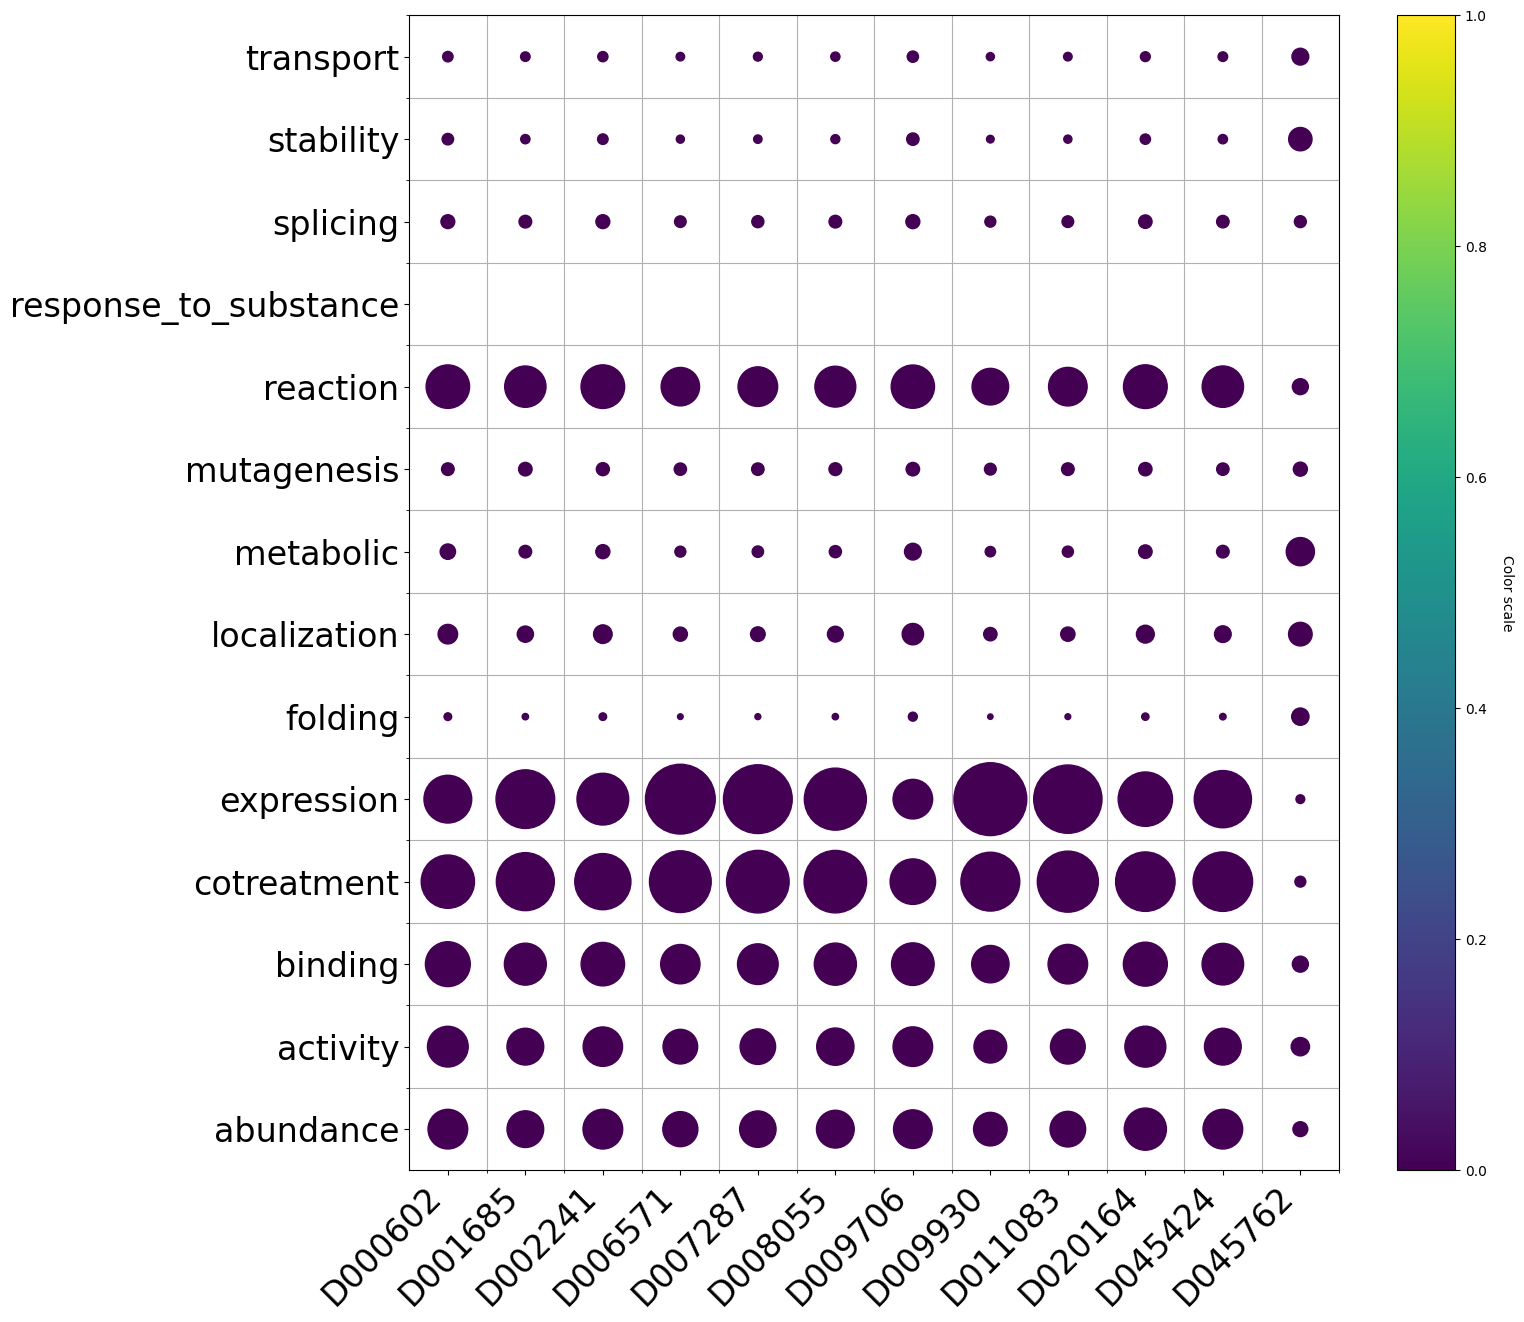

In [69]:

heatmap_color(d_classes_bio_overlap_dict,d_classes_bio_fdr_dict)
plt.savefig('output/Figures/SF1C_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight", transparent=True)

In [70]:
d_classes_bio_fdr_dict

{('D011083', 'folding'): 6.163762929553853e-11,
 ('D011083', 'metabolic'): 5.082544650627861e-35,
 ('D011083', 'stability'): 4.547470323798188e-18,
 ('D011083', 'splicing'): 2.539659855516857e-29,
 ('D011083', 'mutagenesis'): 1.208234125239505e-49,
 ('D011083', 'localization'): 1.2552399817844655e-59,
 ('D011083', 'abundance'): 4.445110367665e-312,
 ('D011083', 'response_to_substance'): 1.0,
 ('D011083', 'transport'): 1.9023463910654266e-13,
 ('D011083', 'binding'): 0.0,
 ('D011083', 'activity'): 3.092824035623818e-296,
 ('D011083', 'reaction'): 1.3045444955100079e-304,
 ('D011083', 'cotreatment'): 0.0,
 ('D011083', 'expression'): 1.6107543966608982e-47,
 ('D006571', 'folding'): 2.039914528565256e-07,
 ('D006571', 'metabolic'): 5.461101807472533e-26,
 ('D006571', 'stability'): 2.079581201622701e-17,
 ('D006571', 'splicing'): 7.577795543395971e-31,
 ('D006571', 'mutagenesis'): 2.2475955852848455e-24,
 ('D006571', 'localization'): 1.761117845886661e-51,
 ('D006571', 'abundance'): 1.23193

In [88]:
#We create a bipartite network for exposures and perturbed genes
bipartite_G = nx.Graph()
exposures_list = []
genes_list = []
for k,v in chem_gene_cleaned.items():
    exposures_list.append(k)
    for gene in v:
        genes_list.append(gene)   
for gene in set(genes_list):
    bipartite_G.add_node(gene,s="^", bipartite='gene')   
for exposure in set(exposures_list):
    bipartite_G.add_node(exposure,s="o", bipartite='exposure')
    for genes in chem_gene_cleaned[exposure]:
        bipartite_G.add_edges_from([(exposure,genes)])

In [89]:
nx.bipartite.is_bipartite(bipartite_G)

True

In [90]:
bipartite_G.number_of_nodes()

35467

In [91]:
bipartite_G.number_of_edges()

573674

In [157]:
#Let's select the top 100 perturbed genes by frequency
gene_nodes = [node for node in bipartite_G.nodes() if bipartite_G.nodes[node]['bipartite'] == 'gene']
genes_degree_dict = nx.bipartite.degree_centrality(bipartite_G, gene_nodes)
gene_nodes_with_centrality={}
for k in genes_degree_dict.keys():
    if k in gene_nodes:
        gene_nodes_with_centrality[k]=genes_degree_dict[k]
        
gene_nodes_with_centrality_sorted = dict(sorted(gene_nodes_with_centrality.items(), key=lambda item: item[1], reverse = True))
dict_items = gene_nodes_with_centrality_sorted.items()
first_ten = list(dict_items)[:10]


In [164]:
first_ten

[('CASP3', 0.17204409831091333),
 ('TNF', 0.12218064124608072),
 ('BCL2', 0.10903206230403562),
 ('CXCL8', 0.10872863355921918),
 ('MAPK1', 0.10569434611105492),
 ('MAPK3', 0.10468291696166684),
 ('BAX', 0.09790634166076667),
 ('CYP3A4', 0.09487205421260242),
 ('TP53', 0.0947709112976636),
 ('IL1B', 0.09143319510468292)]

In [87]:
frequency=[]
for i in range(len(first_ten)):
    label.append(first_ten[i][0])
    frequency.append(len(gene_chem_cleaned[first_ten[i][0]]))

In [88]:
frequency

[1701, 1208, 1078, 1075, 1045, 1035, 968, 938, 937, 904]

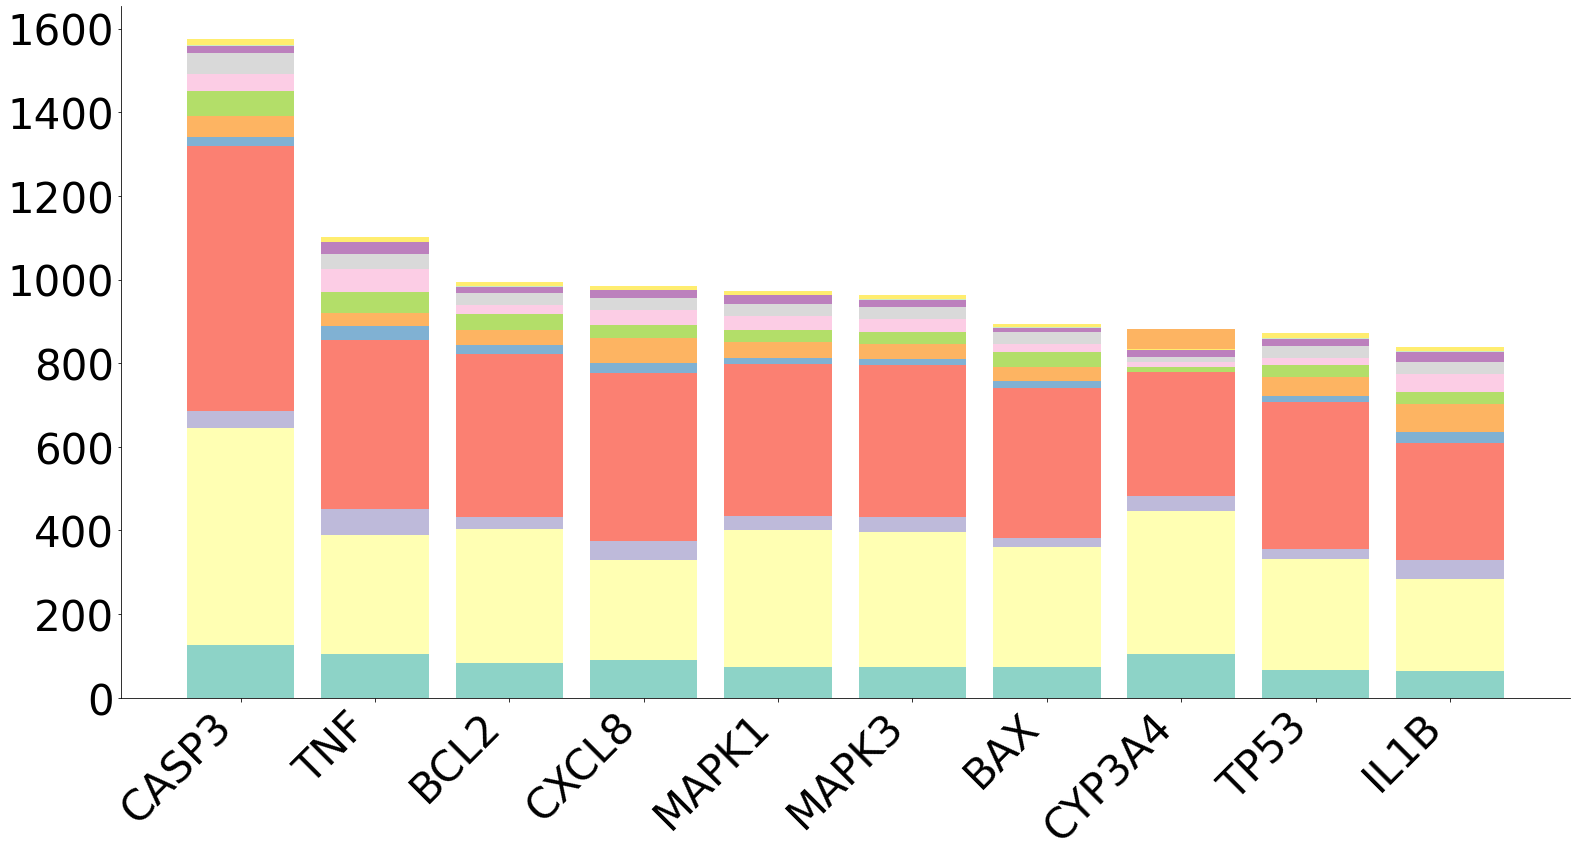

In [32]:
#Here, we show the distribution of the top 100 genes perturbed by frequencies
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator




fig1, ax1 = plt.subplots(figsize=(22, 12))
label=[]
gene_class_comp_dict={}
for i in range(len(first_ten)):
    label.append(first_ten[i][0])  
    gene_comp={}
    for chem in gene_chem_cleaned[first_ten[i][0]]:
        class_list=[]
        for chem_class,chem_list in d_classes.items():
            if chem in chem_list:
                class_list.append(chem_class)
        gene_comp[chem]=class_list
        chem_class_name_gene={}
        for chem_class_name in d_classes.keys():
            count=0
            for chem, class_list in gene_comp.items():
                if chem_class_name in class_list:
                    count=count+(1/len(class_list))
            chem_class_name_gene[chem_class_name]=count
    gene_class_comp_dict[first_ten[i][0]]=chem_class_name_gene
    
    
gene_classes_list=[]
for chem_class_name in d_classes.keys():
    chem_class_value_list=[]
    for gene in label:
        chem_class_value_list.append(gene_class_comp_dict[gene][chem_class_name])
    gene_classes_list.append(chem_class_value_list)

    
x = np.arange(10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)



ax1.bar(label, gene_classes_list[0], label=chem_class_name_dict[list(d_classes.keys())[0]],color=class_color_dict[list(d_classes.keys())[0]])
ax1.bar(label, gene_classes_list[1], bottom=gene_classes_list[0],  label=chem_class_name_dict[list(d_classes.keys())[1]],color=class_color_dict[list(d_classes.keys())[1]])
ax1.bar(label, gene_classes_list[2], bottom=np.array(gene_classes_list[0])+np.array(gene_classes_list[1]),  label=chem_class_name_dict[list(d_classes.keys())[2]],color=class_color_dict[list(d_classes.keys())[2]])
ax1.bar(label, gene_classes_list[3], bottom=np.array(gene_classes_list[0])+np.array(gene_classes_list[1])+np.array(gene_classes_list[2]),  label=chem_class_name_dict[list(d_classes.keys())[3]],color=class_color_dict[list(d_classes.keys())[3]])
ax1.bar(label, gene_classes_list[4], bottom=np.array(gene_classes_list[0])+np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3]),  
        label=chem_class_name_dict[list(d_classes.keys())[4]],color=class_color_dict[list(d_classes.keys())[4]])
ax1.bar(label, gene_classes_list[5], bottom=np.array(gene_classes_list[0])+np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4]),
        label=chem_class_name_dict[list(d_classes.keys())[5]],color=class_color_dict[list(d_classes.keys())[5]])
ax1.bar(label, gene_classes_list[6], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5]),
        label=chem_class_name_dict[list(d_classes.keys())[6]],color=class_color_dict[list(d_classes.keys())[6]])
ax1.bar(label, gene_classes_list[7], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6]),
        label=chem_class_name_dict[list(d_classes.keys())[7]],color=class_color_dict[list(d_classes.keys())[7]])
ax1.bar(label, gene_classes_list[8], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6])+np.array(gene_classes_list[7]),
        label=chem_class_name_dict[list(d_classes.keys())[8]],color=class_color_dict[list(d_classes.keys())[8]])
ax1.bar(label, gene_classes_list[9], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6])+np.array(gene_classes_list[7])+np.array(gene_classes_list[8]),
        label=chem_class_name_dict[list(d_classes.keys())[9]],color=class_color_dict[list(d_classes.keys())[9]])
ax1.bar(label, gene_classes_list[10], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6])+np.array(gene_classes_list[7])+np.array(gene_classes_list[8])+np.array(gene_classes_list[9]),
        label=chem_class_name_dict[list(d_classes.keys())[10]],color=class_color_dict[list(d_classes.keys())[10]])
ax1.bar(label, gene_classes_list[11], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6])+np.array(gene_classes_list[7])+np.array(gene_classes_list[8])+np.array(gene_classes_list[9])+np.array(gene_classes_list[10]),
        label=chem_class_name_dict[list(d_classes.keys())[11]],color=class_color_dict[list(d_classes.keys())[11]])


#plt.title('Frequency of genes affected by exposures',fontsize=32)
#plt.ylabel('Number of associated exposures',fontsize=40)
#plt.xlabel('Genes',fontsize=40)
plt.xticks(x, label,fontsize=42,rotation=45,ha='right')
plt.yticks(fontsize=42)
plt.tight_layout()
#plt.savefig('output/Figures/Fig1F.pdf',format='pdf',dpi=300, bbox_inches = "tight") This is the final Fig. 1G
plt.show()

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_54862/2776258043.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax.get_yticks(), size = 36)


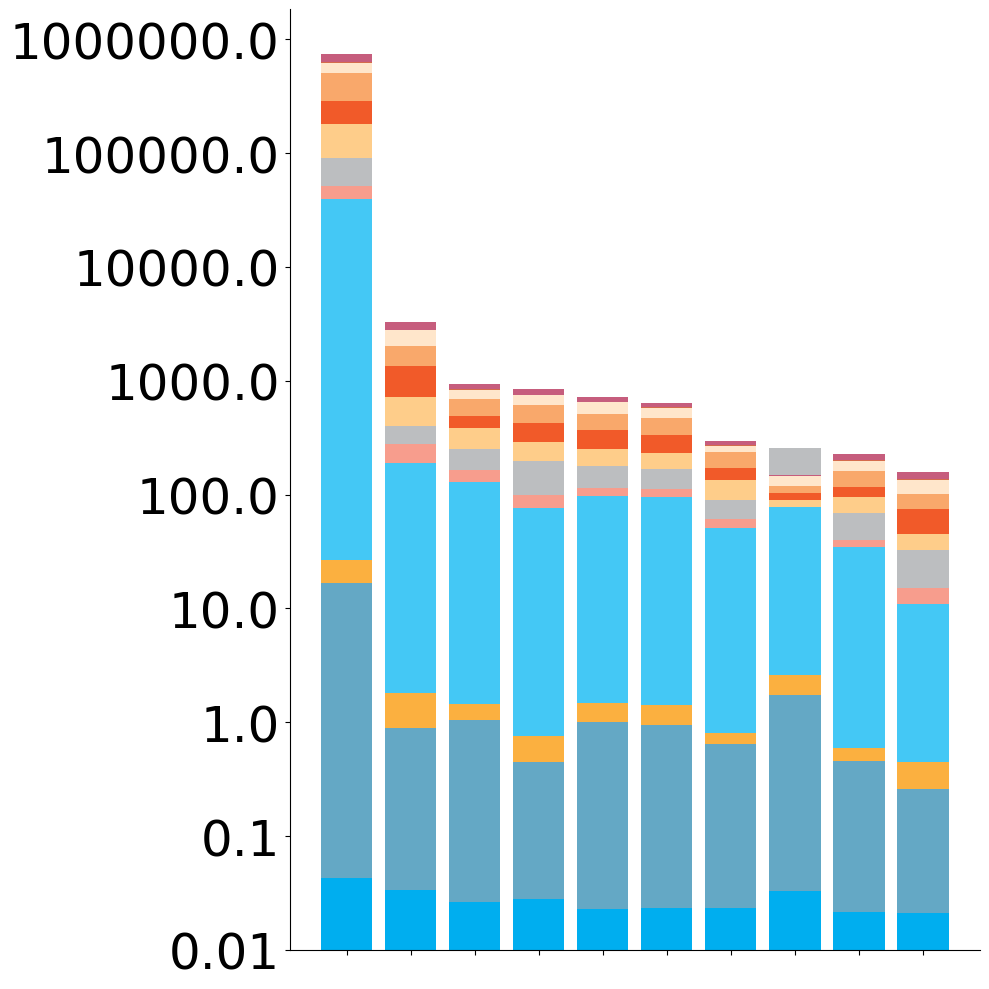

In [163]:
#Here, we show the distribution of the top 100 genes perturbed by frequencies
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator




fig1, ax1 = plt.subplots(figsize=(10, 10))
label=[]
gene_class_comp_dict={}
for i in range(len(first_ten)):
    label.append(first_ten[i][0])  
    gene_comp={}
    for chem in gene_chem_cleaned[first_ten[i][0]]:
        class_list=[]
        for chem_class,chem_list in d_classes.items():
            if chem in chem_list:
                class_list.append(chem_class)
        gene_comp[chem]=class_list
        chem_class_name_gene={}
        for chem_class_name in d_classes.keys():
            count=0
            for chem, class_list in gene_comp.items():
                if chem_class_name in class_list:
                    count=count+(1/len(class_list))
            chem_class_name_gene[chem_class_name]=count
    gene_class_comp_dict[first_ten[i][0]]=chem_class_name_gene
    
    
gene_classes_list=[]
for chem_class_name in d_classes.keys():
    chem_class_value_list=[]
    for gene in label:
        chem_class_value_list.append(gene_class_comp_dict[gene][chem_class_name])
    gene_classes_list.append(chem_class_value_list)

    
x = np.arange(10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)



ax1.bar(label, gene_classes_list[0], label=chem_class_name_dict[list(d_classes.keys())[0]],color=class_color_dict[list(d_classes.keys())[0]])
ax1.bar(label, gene_classes_list[1], bottom=gene_classes_list[0],  label=chem_class_name_dict[list(d_classes.keys())[1]],color=class_color_dict[list(d_classes.keys())[1]])
ax1.bar(label, gene_classes_list[2], bottom=np.array(gene_classes_list[0])+np.array(gene_classes_list[1]),  label=chem_class_name_dict[list(d_classes.keys())[2]],color=class_color_dict[list(d_classes.keys())[2]])
ax1.bar(label, gene_classes_list[3], bottom=np.array(gene_classes_list[0])+np.array(gene_classes_list[1])+np.array(gene_classes_list[2]),  label=chem_class_name_dict[list(d_classes.keys())[3]],color=class_color_dict[list(d_classes.keys())[3]])
ax1.bar(label, gene_classes_list[4], bottom=np.array(gene_classes_list[0])+np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3]),  
        label=chem_class_name_dict[list(d_classes.keys())[4]],color=class_color_dict[list(d_classes.keys())[4]])
ax1.bar(label, gene_classes_list[5], bottom=np.array(gene_classes_list[0])+np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4]),
        label=chem_class_name_dict[list(d_classes.keys())[5]],color=class_color_dict[list(d_classes.keys())[5]])
ax1.bar(label, gene_classes_list[6], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5]),
        label=chem_class_name_dict[list(d_classes.keys())[6]],color=class_color_dict[list(d_classes.keys())[6]])
ax1.bar(label, gene_classes_list[7], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6]),
        label=chem_class_name_dict[list(d_classes.keys())[7]],color=class_color_dict[list(d_classes.keys())[7]])
ax1.bar(label, gene_classes_list[8], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6])+np.array(gene_classes_list[7]),
        label=chem_class_name_dict[list(d_classes.keys())[8]],color=class_color_dict[list(d_classes.keys())[8]])
ax1.bar(label, gene_classes_list[9], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6])+np.array(gene_classes_list[7])+np.array(gene_classes_list[8]),
        label=chem_class_name_dict[list(d_classes.keys())[9]],color=class_color_dict[list(d_classes.keys())[9]])
ax1.bar(label, gene_classes_list[10], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6])+np.array(gene_classes_list[7])+np.array(gene_classes_list[8])+np.array(gene_classes_list[9]),
        label=chem_class_name_dict[list(d_classes.keys())[10]],color=class_color_dict[list(d_classes.keys())[10]])
ax1.bar(label, gene_classes_list[11], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6])+np.array(gene_classes_list[7])+np.array(gene_classes_list[8])+np.array(gene_classes_list[9])+np.array(gene_classes_list[10]),
        label=chem_class_name_dict[list(d_classes.keys())[11]],color=class_color_dict[list(d_classes.keys())[11]])


#plt.title('Frequency of genes affected by exposures',fontsize=32)
#plt.ylabel('Number of associated exposures',fontsize=40)
#plt.xlabel('Genes',fontsize=40)
plt.xticks(x, [],fontsize=42,rotation=45,ha='right')
#plt.yticks(fontsize=42)
ax1.set_yticklabels(ax.get_yticks(), size = 36)
#plt.gca().xaxis.set_major_locator(plt.NullLocator())
#plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.tight_layout()
#plt.savefig('output/Figures/Fig1F.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [36]:
#Let's select the top 100 exposures for number of genes that they perturb
exposure_nodes = [node for node in bipartite_G.nodes() if bipartite_G.nodes[node]['bipartite'] == 'exposure']
exposure_degree_dict = nx.bipartite.degree_centrality(bipartite_G, exposure_nodes)
exposures_nodes_with_centrality={}
for k in exposure_degree_dict.keys():
    if k in exposure_nodes:
        exposures_nodes_with_centrality[k]=exposure_degree_dict[k]
        
exposures_nodes_with_centrality_sorted = dict(sorted(exposures_nodes_with_centrality.items(), key=lambda item: item[1], reverse = True))
dict_items = exposures_nodes_with_centrality_sorted.items()
first_ten = list(dict_items)[:10]



In [47]:
ten_color_dict={}

for i in [el[0] for el in first_ten]:
    label_predecessor=[]
    for j in classes_list_cleaned:
        if j in nx.predecessor(G, i):
            label_predecessor.append(class_color_dict[j])
    ten_color_dict[i]=label_predecessor

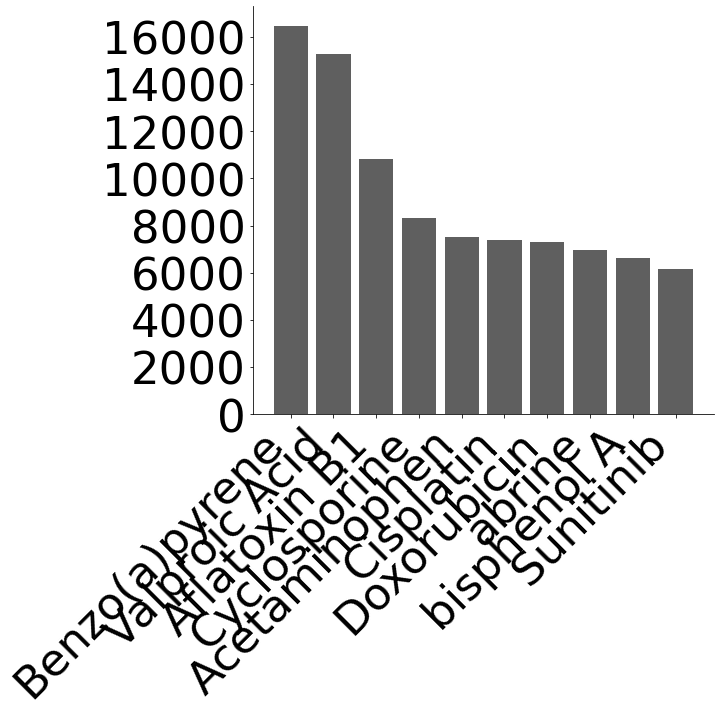

In [55]:
#Let's plot it, color them by their chemical class of belonging 
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
fig1, ax1 = plt.subplots(figsize=(10, 10))
label=[]
new_label=[]
frequency=[]
for i in range(len(first_ten)):
    label.append(first_ten[i][0])
    frequency.append(len(chem_gene_cleaned[first_ten[i][0]]))
    chem_name=chem_id_name_conversion[first_ten[i][0]]
    if len(chem_name)<20:
        new_label.append(chem_name)
    else:
        new_label.append(first_ten[i][0])

x = np.arange(10)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)



    
plt.bar(x, frequency,color='#5F5F5F')
#plt.title('Frequency of exposures rank by their degree',fontsize=32)
#plt.ylabel('Frequency',fontsize=20)
#plt.xlabel('Exposures',fontsize=20)
#plt.xticks(x, new_label,fontsize=45,rotation=45,ha='right')
ax1.set_yticklabels([int(i) for i in list(ax1.get_yticks())], size = 36)
plt.xticks(x, new_label,fontsize=45,rotation=45,ha='right')
#plt.yticks([],fontsize=45,rotation=45,ha='right')
plt.yticks(fontsize=45)
plt.tight_layout()

    
#plt.savefig('output/Figures/Fig1I.pdf',format='pdf',dpi=300, bbox_inches = "tight") 
plt.show()                                                                               

In [84]:
#Let's plot the distribution

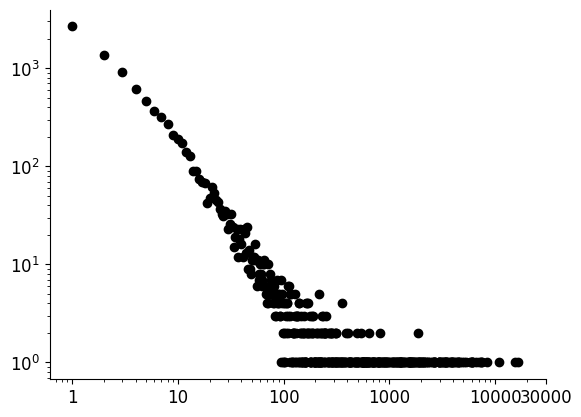

In [144]:
import matplotlib.ticker

exposure_nodes = [node for node in bipartite_G.nodes() if bipartite_G.nodes[node]['bipartite'] == 'exposure']
#Get the exposure degree
exposures_degree_dict = dict(nx.bipartite.degrees(bipartite_G,exposure_nodes)[1])
#Get the unique PPI degree steps
degrees_exposures_unique = list(set(exposures_degree_dict.values()))
degrees_exposures_unique.sort()

#degree for x axis (sorted from small to biggest)
degreesexposures = []

#Normal distribution (i.e. P(k = x))
degreeDistributionexposures = []
degreeDistributionexposurescount = []

for degree in degrees_exposures_unique:
    degreesexposures.append(degree)
    degreeDistributionexposures.append(list(exposures_degree_dict.values()).count(degree)/float(len(exposures_degree_dict)))
    degreeDistributionexposurescount.append(list(exposures_degree_dict.values()).count(degree))

fig1, ax1 = plt.subplots()
plt.scatter(degreesexposures, degreeDistributionexposurescount,c='black',marker="o", alpha=1)
plt.xscale('log')
plt.yscale('log')
#plt.xlabel('Number of genes perturbed by exposure', fontsize=14)
#plt.ylabel('Frequency', fontsize=14)
ax1.set_xticks([1,10, 100, 1000,10000,30000])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
#plt.ylim(10 ** -4.2, 1)
#plt.xlim(0,5000)
#plt.title('Exposures assocciated with genes')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
plt.savefig('output/Figures/SF1D_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()
plt.close()

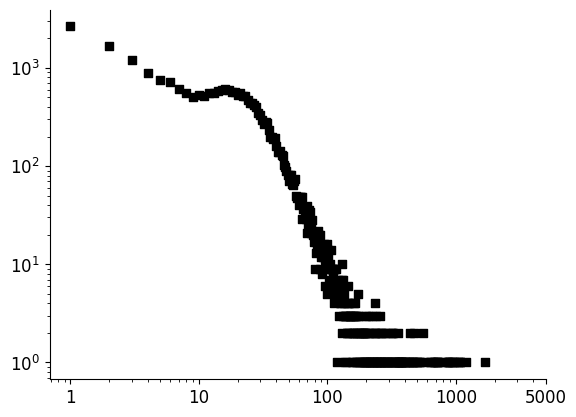

In [148]:
import matplotlib.ticker

gene_nodes = [node for node in bipartite_G.nodes() if bipartite_G.nodes[node]['bipartite'] == 'gene']
#Get the genes degree
genes_degree_dict = dict(nx.bipartite.degrees(bipartite_G,gene_nodes)[1])
#Get the unique PPI degree steps
degrees_genes_unique = list(set(genes_degree_dict.values()))
degrees_genes_unique.sort()

#degree for x axis (sorted from small to biggest)
degreesgenes = []

#Normal distribution (i.e. P(k = x))
degreeDistributiongenes = []
degreeDistributiongenescount = []

for degree in degrees_genes_unique:
    degreesgenes.append(degree)
    degreeDistributiongenes.append(list(genes_degree_dict.values()).count(degree)/float(len(genes_degree_dict)))
    degreeDistributiongenescount.append(list(genes_degree_dict.values()).count(degree))

fig1, ax1 = plt.subplots()
plt.scatter(degreesgenes, degreeDistributiongenescount,c='black',marker="s", alpha=1)
plt.xscale('log')
plt.yscale('log')
#plt.xlabel('Number of genes perturbed by exposure', fontsize=14)
#plt.ylabel('Frequency', fontsize=14)
ax1.set_xticks([1,10, 100, 1000,5000])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
#plt.ylim(10 ** -4.2, 1)
#plt.xlim(0,5000)
#plt.title('Exposures assocciated with genes')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
plt.savefig('output/Figures/SF1E_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()
plt.close()


In [100]:
#HOMO - HQ

#We create a bipartite network for exposures and perturbed genes
bipartite_G_hq = nx.Graph()
exposures_list = []
genes_list = []
for k,v in chem_gene_hq.items():
    exposures_list.append(k)
    for gene in v:
        genes_list.append(gene)   
for gene in set(genes_list):
    bipartite_G_hq.add_node(gene,s="^", bipartite='gene')   
for exposure in set(exposures_list):
    bipartite_G_hq.add_node(exposure,s="o", bipartite='exposure')
    for genes in chem_gene_hq[exposure]:
        bipartite_G_hq.add_edges_from([(exposure,genes)])

In [102]:
bipartite_G_hq.number_of_nodes()

17175

In [103]:
bipartite_G_hq.number_of_edges()

68301

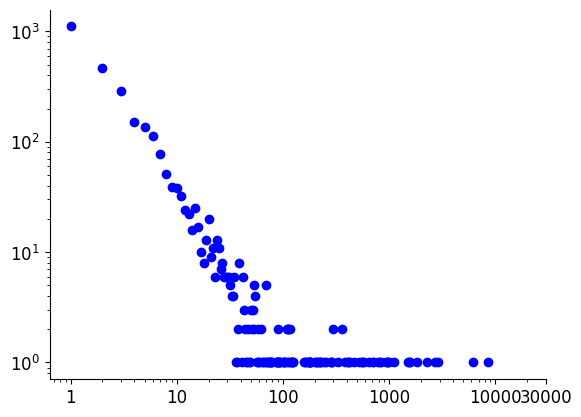

In [149]:
import matplotlib.ticker

exposure_nodes = [node for node in bipartite_G_hq.nodes() if bipartite_G_hq.nodes[node]['bipartite'] == 'exposure']
#Get the exposure degree
exposures_degree_dict = dict(nx.bipartite.degrees(bipartite_G_hq,exposure_nodes)[1])
#Get the unique PPI degree steps
degrees_exposures_unique = list(set(exposures_degree_dict.values()))
degrees_exposures_unique.sort()

#degree for x axis (sorted from small to biggest)
degreesexposures = []

#Normal distribution (i.e. P(k = x))
degreeDistributionexposures = []
degreeDistributionexposurescount = []

for degree in degrees_exposures_unique:
    degreesexposures.append(degree)
    degreeDistributionexposures.append(list(exposures_degree_dict.values()).count(degree)/float(len(exposures_degree_dict)))
    degreeDistributionexposurescount.append(list(exposures_degree_dict.values()).count(degree))

fig1, ax1 = plt.subplots()
plt.scatter(degreesexposures, degreeDistributionexposurescount,c='blue',marker="o", alpha=1)
plt.xscale('log')
plt.yscale('log')
#plt.xlabel('Number of genes perturbed by exposure', fontsize=14)
#plt.ylabel('Frequency', fontsize=14)
ax1.set_xticks([1,10, 100, 1000,10000,30000])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
#plt.ylim(10 ** -4.2, 1)
#plt.xlim(0,5000)
#plt.title('Exposures assocciated with genes')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
plt.savefig('output/Figures/SF1F_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()
plt.close()

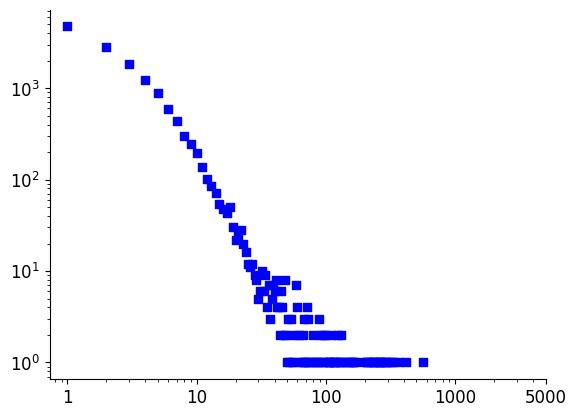

In [151]:
import matplotlib.ticker

gene_nodes = [node for node in bipartite_G_hq.nodes() if bipartite_G_hq.nodes[node]['bipartite'] == 'gene']
#Get the genes degree
genes_degree_dict = dict(nx.bipartite.degrees(bipartite_G_hq,gene_nodes)[1])
#Get the unique PPI degree steps
degrees_genes_unique = list(set(genes_degree_dict.values()))
degrees_genes_unique.sort()

#degree for x axis (sorted from small to biggest)
degreesgenes = []

#Normal distribution (i.e. P(k = x))
degreeDistributiongenes = []
degreeDistributiongenescount = []

for degree in degrees_genes_unique:
    degreesgenes.append(degree)
    degreeDistributiongenes.append(list(genes_degree_dict.values()).count(degree)/float(len(genes_degree_dict)))
    degreeDistributiongenescount.append(list(genes_degree_dict.values()).count(degree))

fig1, ax1 = plt.subplots()
plt.scatter(degreesgenes, degreeDistributiongenescount,c='blue',marker="s", alpha=1)
plt.xscale('log')
plt.yscale('log')
#plt.xlabel('Number of genes perturbed by exposure', fontsize=14)
#plt.ylabel('Frequency', fontsize=14)
ax1.set_xticks([1,10, 100, 1000,5000])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
#plt.ylim(10 ** -4.2, 1)
#plt.xlim(0,5000)
#plt.title('Exposures assocciated with genes')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
plt.savefig('output/Figures/SF1G_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()
plt.close()


In [189]:
#Let's select the top 100 perturbed genes by frequency
gene_nodes = [node for node in bipartite_G_hq.nodes() if bipartite_G_hq.nodes[node]['bipartite'] == 'gene']
genes_degree_dict = nx.bipartite.degree_centrality(bipartite_G_hq, gene_nodes)
gene_nodes_with_centrality={}
for k in genes_degree_dict.keys():
    if k in gene_nodes:
        gene_nodes_with_centrality[k]=genes_degree_dict[k]
        
gene_nodes_with_centrality_sorted = dict(sorted(gene_nodes_with_centrality.items(), key=lambda item: item[1], reverse = True))
dict_items = gene_nodes_with_centrality_sorted.items()
first_ten = list(dict_items)[:10]


In [190]:
first_ten

[('CASP3', 0.19137281752824375),
 ('TNF', 0.14241698048613488),
 ('CXCL8', 0.12529955494693598),
 ('MAPK3', 0.11365970558028073),
 ('MAPK1', 0.10955152345087299),
 ('BCL2', 0.10783978089695309),
 ('TP53', 0.10099281068127353),
 ('IL1B', 0.09859637110578569),
 ('IL6', 0.09483053748716193),
 ('CYP3A4', 0.09174940089010612)]

In [167]:
#Let's build also the vice-versa: the gene-chem dictionary


gene_chem_hq = {}
for i,v in chem_gene_ref_df.iterrows():
    if v['PubMedIDs']>1:
        try:
            gene_chem_hq[v["GeneSymbol"]] |= {v["ChemicalID"]}
        except KeyError as e:
            gene_chem_hq[v["GeneSymbol"]] = set([v["ChemicalID"]])
    else:
        pass

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_54862/3663160202.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax.get_yticks(), size = 36)


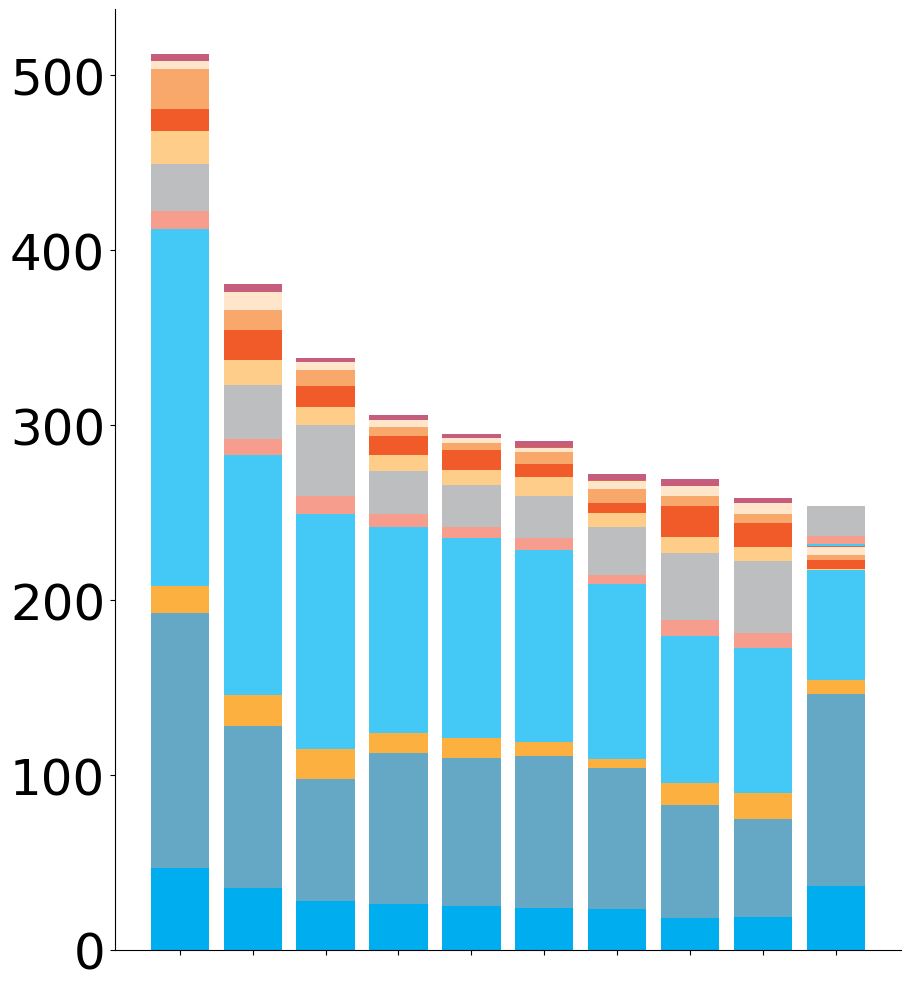

In [191]:
#Here, we show the distribution of the top 100 genes perturbed by frequencies
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator




fig1, ax1 = plt.subplots(figsize=(10, 10))
label=[]
gene_class_comp_dict={}
for i in range(len(first_ten)):
    label.append(first_ten[i][0])  
    gene_comp={}
    for chem in gene_chem_hq[first_ten[i][0]]:
        class_list=[]
        for chem_class,chem_list in d_classes.items():
            if chem in chem_list:
                class_list.append(chem_class)
        gene_comp[chem]=class_list
        chem_class_name_gene={}
        for chem_class_name in d_classes.keys():
            count=0
            for chem, class_list in gene_comp.items():
                if chem_class_name in class_list:
                    count=count+(1/len(class_list))
            chem_class_name_gene[chem_class_name]=count
    gene_class_comp_dict[first_ten[i][0]]=chem_class_name_gene
    
    
gene_classes_list=[]
for chem_class_name in d_classes.keys():
    chem_class_value_list=[]
    for gene in label:
        chem_class_value_list.append(gene_class_comp_dict[gene][chem_class_name])
    gene_classes_list.append(chem_class_value_list)

    
x = np.arange(10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)



ax1.bar(label, gene_classes_list[0], label=chem_class_name_dict[list(d_classes.keys())[0]],color=class_color_dict[list(d_classes.keys())[0]])
ax1.bar(label, gene_classes_list[1], bottom=gene_classes_list[0],  label=chem_class_name_dict[list(d_classes.keys())[1]],color=class_color_dict[list(d_classes.keys())[1]])
ax1.bar(label, gene_classes_list[2], bottom=np.array(gene_classes_list[0])+np.array(gene_classes_list[1]),  label=chem_class_name_dict[list(d_classes.keys())[2]],color=class_color_dict[list(d_classes.keys())[2]])
ax1.bar(label, gene_classes_list[3], bottom=np.array(gene_classes_list[0])+np.array(gene_classes_list[1])+np.array(gene_classes_list[2]),  label=chem_class_name_dict[list(d_classes.keys())[3]],color=class_color_dict[list(d_classes.keys())[3]])
ax1.bar(label, gene_classes_list[4], bottom=np.array(gene_classes_list[0])+np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3]),  
        label=chem_class_name_dict[list(d_classes.keys())[4]],color=class_color_dict[list(d_classes.keys())[4]])
ax1.bar(label, gene_classes_list[5], bottom=np.array(gene_classes_list[0])+np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4]),
        label=chem_class_name_dict[list(d_classes.keys())[5]],color=class_color_dict[list(d_classes.keys())[5]])
ax1.bar(label, gene_classes_list[6], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5]),
        label=chem_class_name_dict[list(d_classes.keys())[6]],color=class_color_dict[list(d_classes.keys())[6]])
ax1.bar(label, gene_classes_list[7], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6]),
        label=chem_class_name_dict[list(d_classes.keys())[7]],color=class_color_dict[list(d_classes.keys())[7]])
ax1.bar(label, gene_classes_list[8], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6])+np.array(gene_classes_list[7]),
        label=chem_class_name_dict[list(d_classes.keys())[8]],color=class_color_dict[list(d_classes.keys())[8]])
ax1.bar(label, gene_classes_list[9], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6])+np.array(gene_classes_list[7])+np.array(gene_classes_list[8]),
        label=chem_class_name_dict[list(d_classes.keys())[9]],color=class_color_dict[list(d_classes.keys())[9]])
ax1.bar(label, gene_classes_list[10], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6])+np.array(gene_classes_list[7])+np.array(gene_classes_list[8])+np.array(gene_classes_list[9]),
        label=chem_class_name_dict[list(d_classes.keys())[10]],color=class_color_dict[list(d_classes.keys())[10]])
ax1.bar(label, gene_classes_list[11], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6])+np.array(gene_classes_list[7])+np.array(gene_classes_list[8])+np.array(gene_classes_list[9])+np.array(gene_classes_list[10]),
        label=chem_class_name_dict[list(d_classes.keys())[11]],color=class_color_dict[list(d_classes.keys())[11]])


#plt.title('Frequency of genes affected by exposures',fontsize=32)
#plt.ylabel('Number of associated exposures',fontsize=40)
#plt.xlabel('Genes',fontsize=40)
plt.xticks(x, [],fontsize=42,rotation=45,ha='right')
#plt.yticks(fontsize=42)
ax1.set_yticklabels(ax.get_yticks(), size = 36)
#plt.gca().xaxis.set_major_locator(plt.NullLocator())
#plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.tight_layout()
plt.yscale("linear")
plt.savefig('output/Figures/SF1I_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [170]:
exposure_nodes = [node for node in bipartite_G_hq.nodes() if bipartite_G_hq.nodes[node]['bipartite'] == 'exposure']
exposure_degree_dict = nx.bipartite.degree_centrality(bipartite_G_hq, exposure_nodes)
exposures_nodes_with_centrality={}
for k in exposure_degree_dict.keys():
    if k in exposure_nodes:
        exposures_nodes_with_centrality[k]=exposure_degree_dict[k]
        
exposures_nodes_with_centrality_sorted = dict(sorted(exposures_nodes_with_centrality.items(), key=lambda item: item[1], reverse = True))
dict_items = exposures_nodes_with_centrality_sorted.items()
first_ten = list(dict_items)[:10]


In [171]:
first_ten

[('D014635', 0.6004630279219868),
 ('D001564', 0.4362284271081801),
 ('D016604', 0.20408306440297458),
 ('D010662', 0.18984144801459238),
 ('C012589', 0.1593938543566718),
 ('D004958', 0.12768345727515082),
 ('C006780', 0.11084607829381225),
 ('D002945', 0.10951311912445628),
 ('C118739', 0.10551424161638838),
 ('D016572', 0.07899536972078013)]

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_54862/1224641146.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(i) for i in list(ax1.get_yticks())], size = 36)


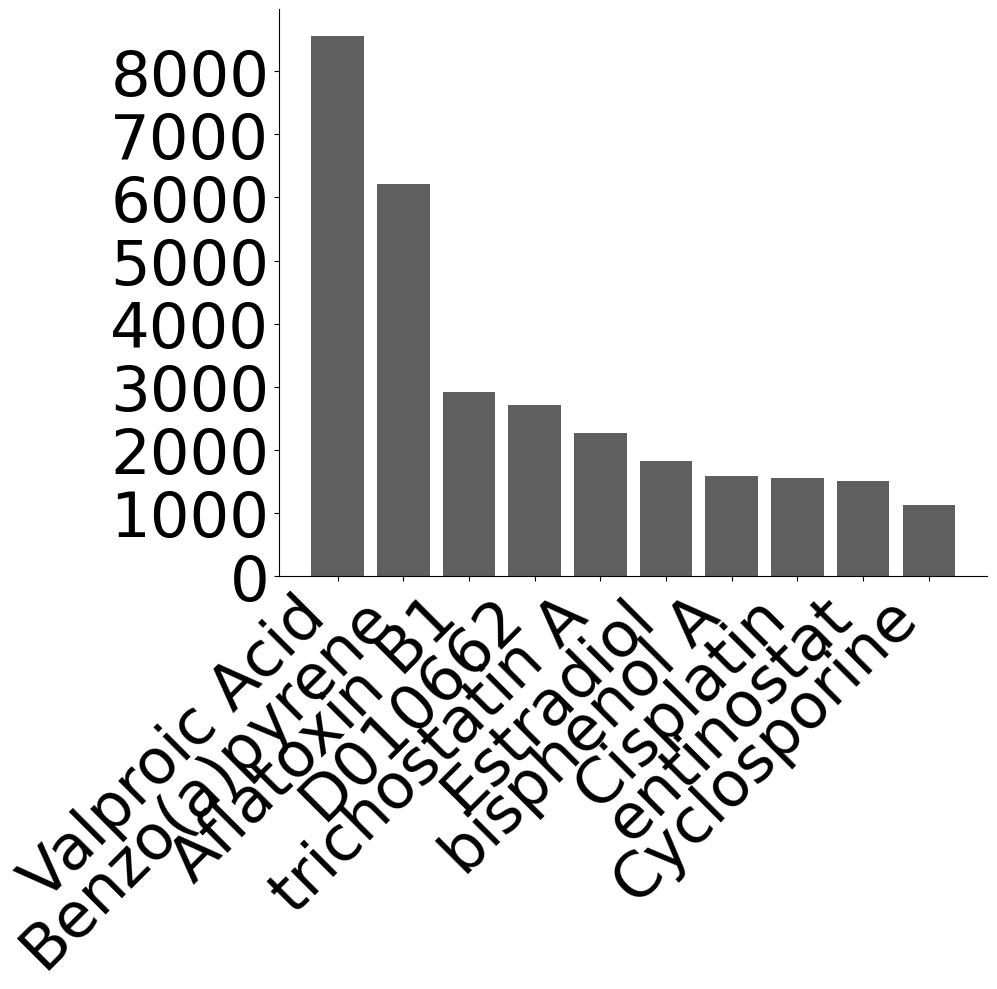

In [175]:
#Let's plot it, color them by their chemical class of belonging 
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
fig1, ax1 = plt.subplots(figsize=(10, 10))
label=[]
new_label=[]
frequency=[]
for i in range(len(first_ten)):
    label.append(first_ten[i][0])
    frequency.append(len(chem_gene_hq[first_ten[i][0]]))
    chem_name=chem_id_name_conversion[first_ten[i][0]]
    if len(chem_name)<20:
        new_label.append(chem_name)
    else:
        new_label.append(first_ten[i][0])

x = np.arange(10)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)



    
plt.bar(x, frequency,color='#5F5F5F')
#plt.title('Frequency of exposures rank by their degree',fontsize=32)
#plt.ylabel('Frequency',fontsize=20)
#plt.xlabel('Exposures',fontsize=20)
#plt.xticks(x, new_label,fontsize=45,rotation=45,ha='right')
ax1.set_yticklabels([int(i) for i in list(ax1.get_yticks())], size = 36)
plt.xticks(x, new_label,fontsize=45,rotation=45,ha='right')
#plt.yticks([],fontsize=45,rotation=45,ha='right')
plt.yticks(fontsize=45)
plt.tight_layout()

plt.savefig('output/Figures/SF1L_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")

plt.show() 

In [108]:
#HOMO - Mouse

#We create a bipartite network for exposures and perturbed genes
bipartite_G_homo_mouse = nx.Graph()
exposures_list = []
genes_list = []
for k,v in chem_gene_homo_mouse.items():
    exposures_list.append(k)
    for gene in v:
        genes_list.append(gene)   
for gene in set(genes_list):
    bipartite_G_homo_mouse.add_node(gene,s="^", bipartite='gene')   
for exposure in set(exposures_list):
    bipartite_G_homo_mouse.add_node(exposure,s="o", bipartite='exposure')
    for genes in chem_gene_homo_mouse[exposure]:
        bipartite_G_homo_mouse.add_edges_from([(exposure,genes)])

In [109]:
bipartite_G_homo_mouse.number_of_nodes()

41905

In [110]:
bipartite_G_homo_mouse.number_of_edges()

894931

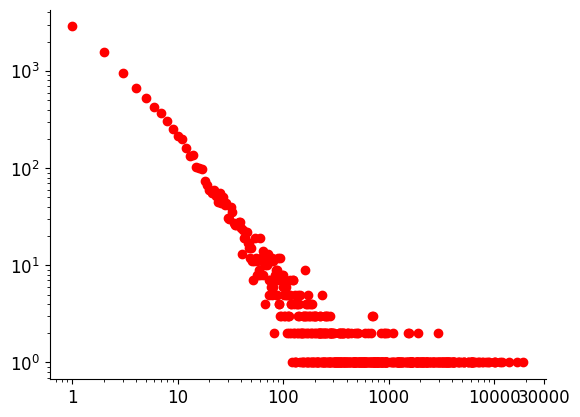

In [152]:
import matplotlib.ticker

exposure_nodes = [node for node in bipartite_G_homo_mouse.nodes() if bipartite_G_homo_mouse.nodes[node]['bipartite'] == 'exposure']
#Get the exposure degree
exposures_degree_dict = dict(nx.bipartite.degrees(bipartite_G_homo_mouse,exposure_nodes)[1])
#Get the unique PPI degree steps
degrees_exposures_unique = list(set(exposures_degree_dict.values()))
degrees_exposures_unique.sort()

#degree for x axis (sorted from small to biggest)
degreesexposures = []

#Normal distribution (i.e. P(k = x))
degreeDistributionexposures = []
degreeDistributionexposurescount = []

for degree in degrees_exposures_unique:
    degreesexposures.append(degree)
    degreeDistributionexposures.append(list(exposures_degree_dict.values()).count(degree)/float(len(exposures_degree_dict)))
    degreeDistributionexposurescount.append(list(exposures_degree_dict.values()).count(degree))

fig1, ax1 = plt.subplots()
plt.scatter(degreesexposures, degreeDistributionexposurescount,c='red',marker="o", alpha=1)
plt.xscale('log')
plt.yscale('log')
#plt.xlabel('Number of genes perturbed by exposure', fontsize=14)
#plt.ylabel('Frequency', fontsize=14)
ax1.set_xticks([1,10, 100, 1000,10000,30000])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
#plt.ylim(10 ** -4.2, 1)
#plt.xlim(0,5000)
#plt.title('Exposures assocciated with genes')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
plt.savefig('output/Figures/SF1J_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()
plt.close()

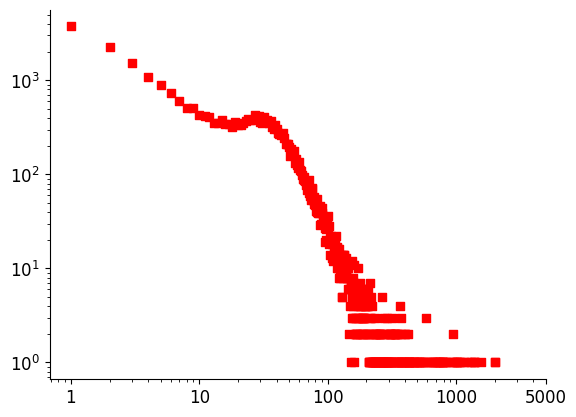

In [153]:
import matplotlib.ticker

gene_nodes = [node for node in bipartite_G_homo_mouse.nodes() if bipartite_G_homo_mouse.nodes[node]['bipartite'] == 'gene']
#Get the genes degree
genes_degree_dict = dict(nx.bipartite.degrees(bipartite_G_homo_mouse,gene_nodes)[1])
#Get the unique PPI degree steps
degrees_genes_unique = list(set(genes_degree_dict.values()))
degrees_genes_unique.sort()

#degree for x axis (sorted from small to biggest)
degreesgenes = []

#Normal distribution (i.e. P(k = x))
degreeDistributiongenes = []
degreeDistributiongenescount = []

for degree in degrees_genes_unique:
    degreesgenes.append(degree)
    degreeDistributiongenes.append(list(genes_degree_dict.values()).count(degree)/float(len(genes_degree_dict)))
    degreeDistributiongenescount.append(list(genes_degree_dict.values()).count(degree))

fig1, ax1 = plt.subplots()
plt.scatter(degreesgenes, degreeDistributiongenescount,c='red',marker="s", alpha=1)
plt.xscale('log')
plt.yscale('log')
#plt.xlabel('Number of genes perturbed by exposure', fontsize=14)
#plt.ylabel('Frequency', fontsize=14)
ax1.set_xticks([1,10, 100, 1000,5000])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
#plt.ylim(10 ** -4.2, 1)
#plt.xlim(0,5000)
#plt.title('Exposures assocciated with genes')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
plt.savefig('output/Figures/SF1H_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()
plt.close()

In [186]:
#Let's select the top 100 perturbed genes by frequency
gene_nodes = [node for node in bipartite_G_homo_mouse.nodes() if bipartite_G_homo_mouse.nodes[node]['bipartite'] == 'gene']
genes_degree_dict = nx.bipartite.degree_centrality(bipartite_G_homo_mouse, gene_nodes)
gene_nodes_with_centrality={}
for k in genes_degree_dict.keys():
    if k in gene_nodes:
        gene_nodes_with_centrality[k]=genes_degree_dict[k]
        
gene_nodes_with_centrality_sorted = dict(sorted(gene_nodes_with_centrality.items(), key=lambda item: item[1], reverse = True))
dict_items = gene_nodes_with_centrality_sorted.items()
first_ten = list(dict_items)[:10]

In [177]:
first_ten

[('CASP3', 0.17808339173090398),
 ('TNF', 0.1771198318149965),
 ('IL6', 0.1362999299229152),
 ('IL1B', 0.12386124737210931),
 ('MAPK1', 0.12175893482831114),
 ('MAPK3', 0.12123335669236159),
 ('BCL2', 0.11571478626489137),
 ('BAX', 0.10739313244569025),
 ('PTGS2', 0.1013489838822705),
 ('CXCL8', 0.09477925718290119)]

In [178]:
gene_chem_mouse = {}
for i,v in chem_homo_mouse.iterrows():
    try:
        gene_chem_mouse[v["GeneSymbol"]] |= {v["ChemicalID"]}
    except KeyError as e:
        gene_chem_mouse[v["GeneSymbol"]] = set([v["ChemicalID"]])

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_54862/3579619186.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax.get_yticks(), size = 36)


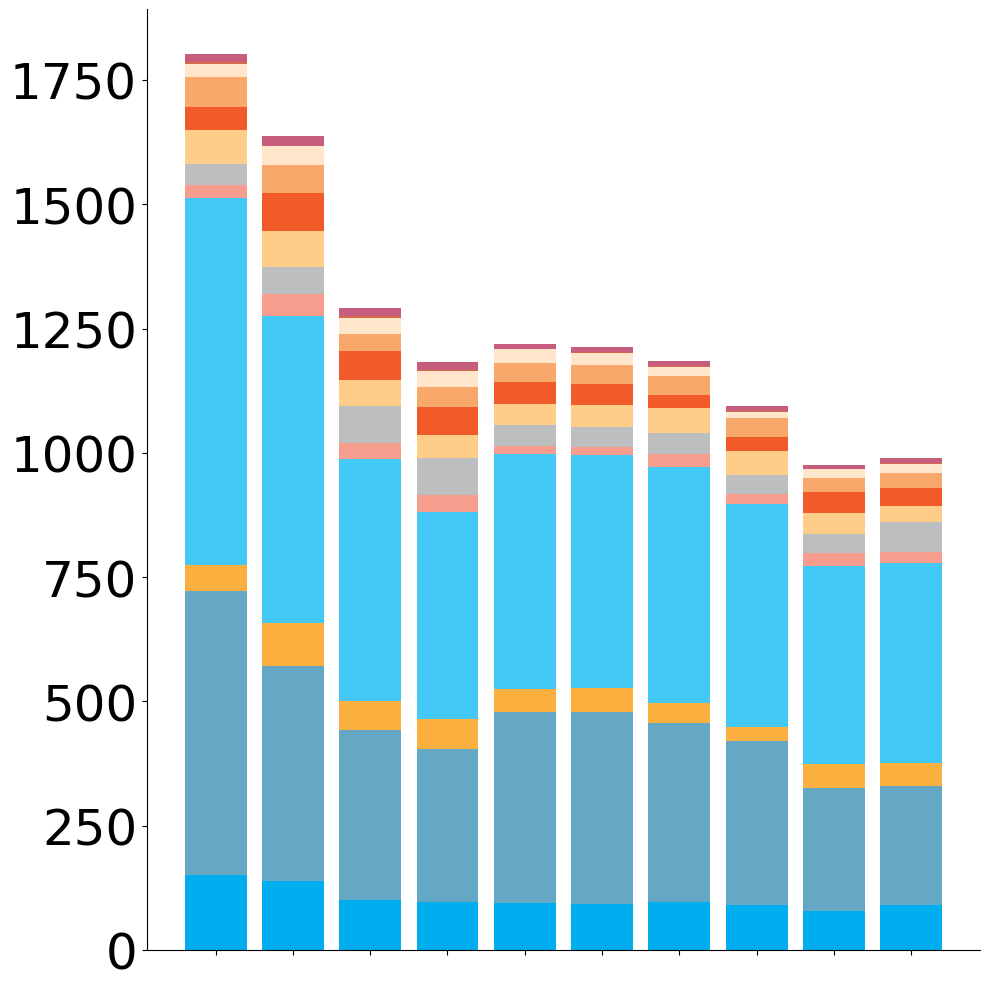

In [188]:
#Here, we show the distribution of the top 10 genes perturbed by frequencies
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator


fig1, ax1 = plt.subplots(figsize=(10, 10))
label=[]
gene_class_comp_dict={}
for i in range(len(first_ten)):
    label.append(first_ten[i][0])  
    gene_comp={}
    for chem in gene_chem_mouse[first_ten[i][0]]:
        class_list=[]
        for chem_class,chem_list in d_classes.items():
            if chem in chem_list:
                class_list.append(chem_class)
        gene_comp[chem]=class_list
        chem_class_name_gene={}
        for chem_class_name in d_classes.keys():
            count=0
            for chem, class_list in gene_comp.items():
                if chem_class_name in class_list:
                    count=count+(1/len(class_list))
            chem_class_name_gene[chem_class_name]=count
    gene_class_comp_dict[first_ten[i][0]]=chem_class_name_gene
    
    
gene_classes_list=[]
for chem_class_name in d_classes.keys():
    chem_class_value_list=[]
    for gene in label:
        chem_class_value_list.append(gene_class_comp_dict[gene][chem_class_name])
    gene_classes_list.append(chem_class_value_list)

    
x = np.arange(10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)



ax1.bar(label, gene_classes_list[0], label=chem_class_name_dict[list(d_classes.keys())[0]],color=class_color_dict[list(d_classes.keys())[0]])
ax1.bar(label, gene_classes_list[1], bottom=gene_classes_list[0],  label=chem_class_name_dict[list(d_classes.keys())[1]],color=class_color_dict[list(d_classes.keys())[1]])
ax1.bar(label, gene_classes_list[2], bottom=np.array(gene_classes_list[0])+np.array(gene_classes_list[1]),  label=chem_class_name_dict[list(d_classes.keys())[2]],color=class_color_dict[list(d_classes.keys())[2]])
ax1.bar(label, gene_classes_list[3], bottom=np.array(gene_classes_list[0])+np.array(gene_classes_list[1])+np.array(gene_classes_list[2]),  label=chem_class_name_dict[list(d_classes.keys())[3]],color=class_color_dict[list(d_classes.keys())[3]])
ax1.bar(label, gene_classes_list[4], bottom=np.array(gene_classes_list[0])+np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3]),  
        label=chem_class_name_dict[list(d_classes.keys())[4]],color=class_color_dict[list(d_classes.keys())[4]])
ax1.bar(label, gene_classes_list[5], bottom=np.array(gene_classes_list[0])+np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4]),
        label=chem_class_name_dict[list(d_classes.keys())[5]],color=class_color_dict[list(d_classes.keys())[5]])
ax1.bar(label, gene_classes_list[6], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5]),
        label=chem_class_name_dict[list(d_classes.keys())[6]],color=class_color_dict[list(d_classes.keys())[6]])
ax1.bar(label, gene_classes_list[7], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6]),
        label=chem_class_name_dict[list(d_classes.keys())[7]],color=class_color_dict[list(d_classes.keys())[7]])
ax1.bar(label, gene_classes_list[8], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6])+np.array(gene_classes_list[7]),
        label=chem_class_name_dict[list(d_classes.keys())[8]],color=class_color_dict[list(d_classes.keys())[8]])
ax1.bar(label, gene_classes_list[9], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6])+np.array(gene_classes_list[7])+np.array(gene_classes_list[8]),
        label=chem_class_name_dict[list(d_classes.keys())[9]],color=class_color_dict[list(d_classes.keys())[9]])
ax1.bar(label, gene_classes_list[10], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6])+np.array(gene_classes_list[7])+np.array(gene_classes_list[8])+np.array(gene_classes_list[9]),
        label=chem_class_name_dict[list(d_classes.keys())[10]],color=class_color_dict[list(d_classes.keys())[10]])
ax1.bar(label, gene_classes_list[11], bottom=np.array(gene_classes_list[1])+np.array(gene_classes_list[2])+np.array(gene_classes_list[3])+np.array(gene_classes_list[4])+np.array(gene_classes_list[5])+np.array(gene_classes_list[6])+np.array(gene_classes_list[7])+np.array(gene_classes_list[8])+np.array(gene_classes_list[9])+np.array(gene_classes_list[10]),
        label=chem_class_name_dict[list(d_classes.keys())[11]],color=class_color_dict[list(d_classes.keys())[11]])


#plt.title('Frequency of genes affected by exposures',fontsize=32)
#plt.ylabel('Number of associated exposures',fontsize=40)
#plt.xlabel('Genes',fontsize=40)
plt.xticks(x, [],fontsize=42,rotation=45,ha='right')
#plt.yticks(fontsize=42)
ax1.set_yticklabels(ax.get_yticks(), size = 36)
#plt.gca().xaxis.set_major_locator(plt.NullLocator())
#plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.yscale("linear")
plt.tight_layout()
plt.savefig('output/Figures/SF1M_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [180]:
exposure_nodes = [node for node in bipartite_G_homo_mouse.nodes() if bipartite_G_homo_mouse.nodes[node]['bipartite'] == 'exposure']
exposure_degree_dict = nx.bipartite.degree_centrality(bipartite_G_homo_mouse, exposure_nodes)
exposures_nodes_with_centrality={}
for k in exposure_degree_dict.keys():
    if k in exposure_nodes:
        exposures_nodes_with_centrality[k]=exposure_degree_dict[k]
        
exposures_nodes_with_centrality_sorted = dict(sorted(exposures_nodes_with_centrality.items(), key=lambda item: item[1], reverse = True))
dict_items = exposures_nodes_with_centrality_sorted.items()
first_ten = list(dict_items)[:10]


In [181]:
first_ten

[('D001564', 0.6200596936600086),
 ('D014635', 0.5378005182196858),
 ('D013749', 0.4558365312079767),
 ('D016604', 0.393682967627669),
 ('D000082', 0.37105185476729313),
 ('D019813', 0.3379579520482797),
 ('C006780', 0.33323493719046215),
 ('D005492', 0.3281511364754502),
 ('D001335', 0.29456525304208075),
 ('D016572', 0.2878743153268392)]

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_54862/2969597823.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([int(i) for i in list(ax1.get_yticks())], size = 36)


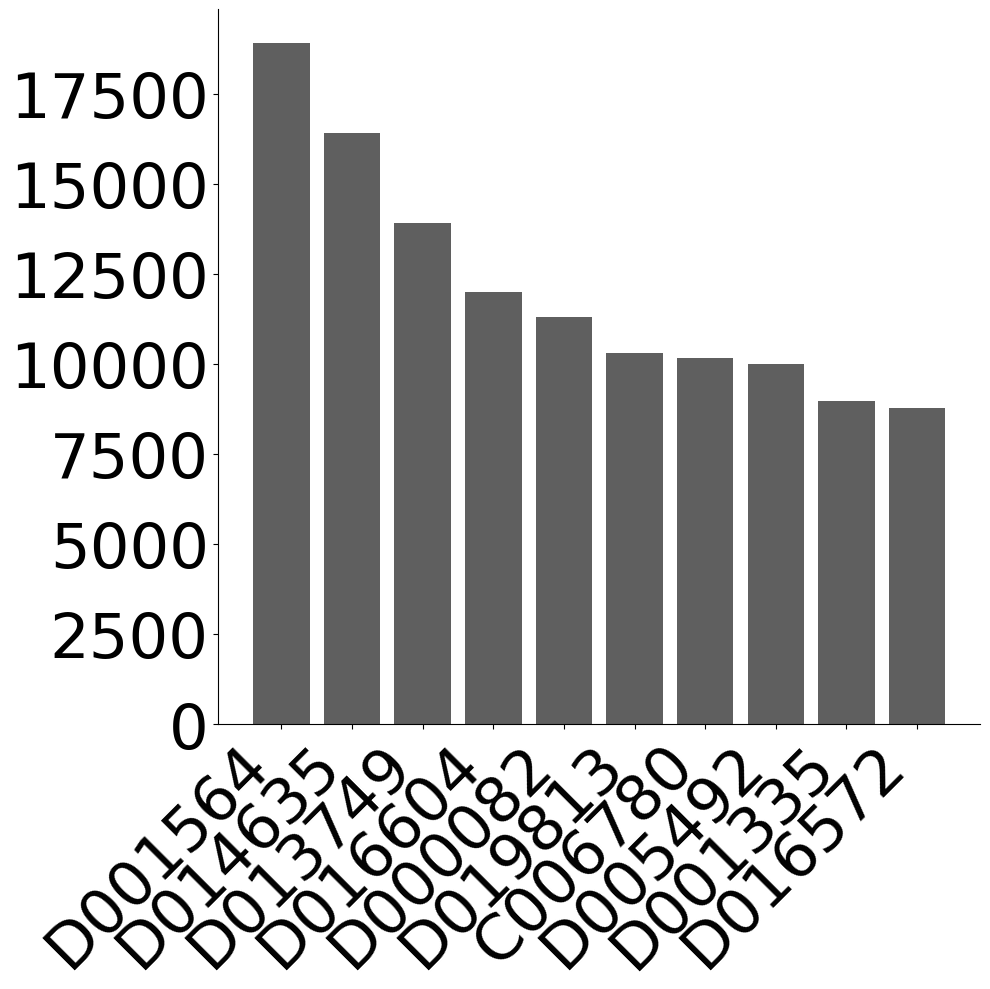

In [184]:
#Let's plot it, color them by their chemical class of belonging 
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
fig1, ax1 = plt.subplots(figsize=(10, 10))
label=[]
new_label=[]
frequency=[]
for i in range(len(first_ten)):
    label.append(first_ten[i][0])
    frequency.append(len(chem_gene_homo_mouse[first_ten[i][0]]))


x = np.arange(10)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)



    
plt.bar(x, frequency,color='#5F5F5F')
#plt.title('Frequency of exposures rank by their degree',fontsize=32)
#plt.ylabel('Frequency',fontsize=20)
#plt.xlabel('Exposures',fontsize=20)
#plt.xticks(x, new_label,fontsize=45,rotation=45,ha='right')
ax1.set_yticklabels([int(i) for i in list(ax1.get_yticks())], size = 36)
plt.xticks(x, label,fontsize=45,rotation=45,ha='right')
#plt.yticks([],fontsize=45,rotation=45,ha='right')
plt.yticks(fontsize=45)
plt.tight_layout()

plt.savefig('output/Figures/SF1N_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")

plt.show() 